# Introduction to Data Science and Machine Learning

<p align="center">
    <img width="699" alt="image" src="https://user-images.githubusercontent.com/49638680/159042792-8510fbd1-c4ac-4a48-8320-bc6c1a49cdae.png">
</p>

---

## Model issues

In this lecture we start to describe the main possible issues with machine learning models.

Let's start by revising an example with a _polynomial regression_.

Consider the problem of predicting $y \in \mathbb{R}$ from $x \in \mathbb{R}$.

Consider the set of fits below. 

<p align="center">
    <img width="951" alt="image" src="https://user-images.githubusercontent.com/49638680/162145915-a5201fce-fa50-4944-8baf-295a1abb92ac.png">
</p>

The yellow one shows the result of a linear fitting $y = \beta_0 + \beta_1 x$.

One can see by looking at point positions, this is not a good fit.

If we add an extra feature, $x^2$, hence the fit is $y = \beta_0 + \beta_1 x + \beta_2 x^2$, we obtain a slightly better fit. 
Naively, one can think that the more features one adds the better fit one gets. However, despite how seducing is the idea, this is actually dangerous. The red fit in the picture is the result of a $7$-rank polynomial $y = \sum_k \beta_k x^k$. 
We see that even though the fitted curve passes through the data perfectly, we would not expect this to be a very good predictor of, say, housing prices.


### Import libraries

In [1]:
# Import libraries we will need in the following
import pandas as pd
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures

# set plot size
plt.rcParams['figure.figsize'] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## The polynomial regression

In the last lecture we analysed the polynomial regression fit.
Let's revise it together.

First, we import data into a python object, in this case a dictionary.

In [2]:
dataset = sio.loadmat('datasets/dataset.mat') # load a .mat file. Recall the function loadmat returns a dictionary

We can split into train and test.

In [3]:
# Give names to variables

X = dataset['X']
X_test = dataset['Xtest']
X_val = dataset['Xval']
y = dataset['y']
y_test = dataset['ytest']
y_val = dataset['yval']

For the moment being, let's focus on the pandas DataFrame containing the full dataset values stored in `X` and `y`.

In [4]:
measures = pd.DataFrame({'Change in water level' : X.flatten(), 'Water flowing out of the dam': y.flatten()})

In [5]:
measures = measures.sort_values(by = ['Change in water level']) 

We have already discussed the need of sorting values, otherwise the plot would be awful.

Let's redefine the function to plot data and their fit polynomial with a parametric rank.

In [6]:
def plot_poly(x, y, xlabel, ylabel, max_degree = 10):
    """
        :return: plots of data in measures, with axis legends given by xlabel and ylabel, and polynomial trend curves
        from degree 0 to max_degree (default = 10).
    """
    for k in range(max_degree + 1):
        measures.plot(kind='scatter', x = xlabel, y = ylabel, color='blue', figsize=(17,10))
        z = np.polyfit(x, y, k)
        p = np.poly1d(z)
        plt.plot(x, p(x), "r--", label='polynomial of degree %s'%k)
        pst = plt.legend(loc='lower right', frameon=True)
        plt.show()

In [7]:
x = measures['Change in water level']
y = measures['Water flowing out of the dam']
xlabel = 'Change in water level'
ylabel = 'Water flowing out of the dam'

Call the function defined above to plot curve trends.

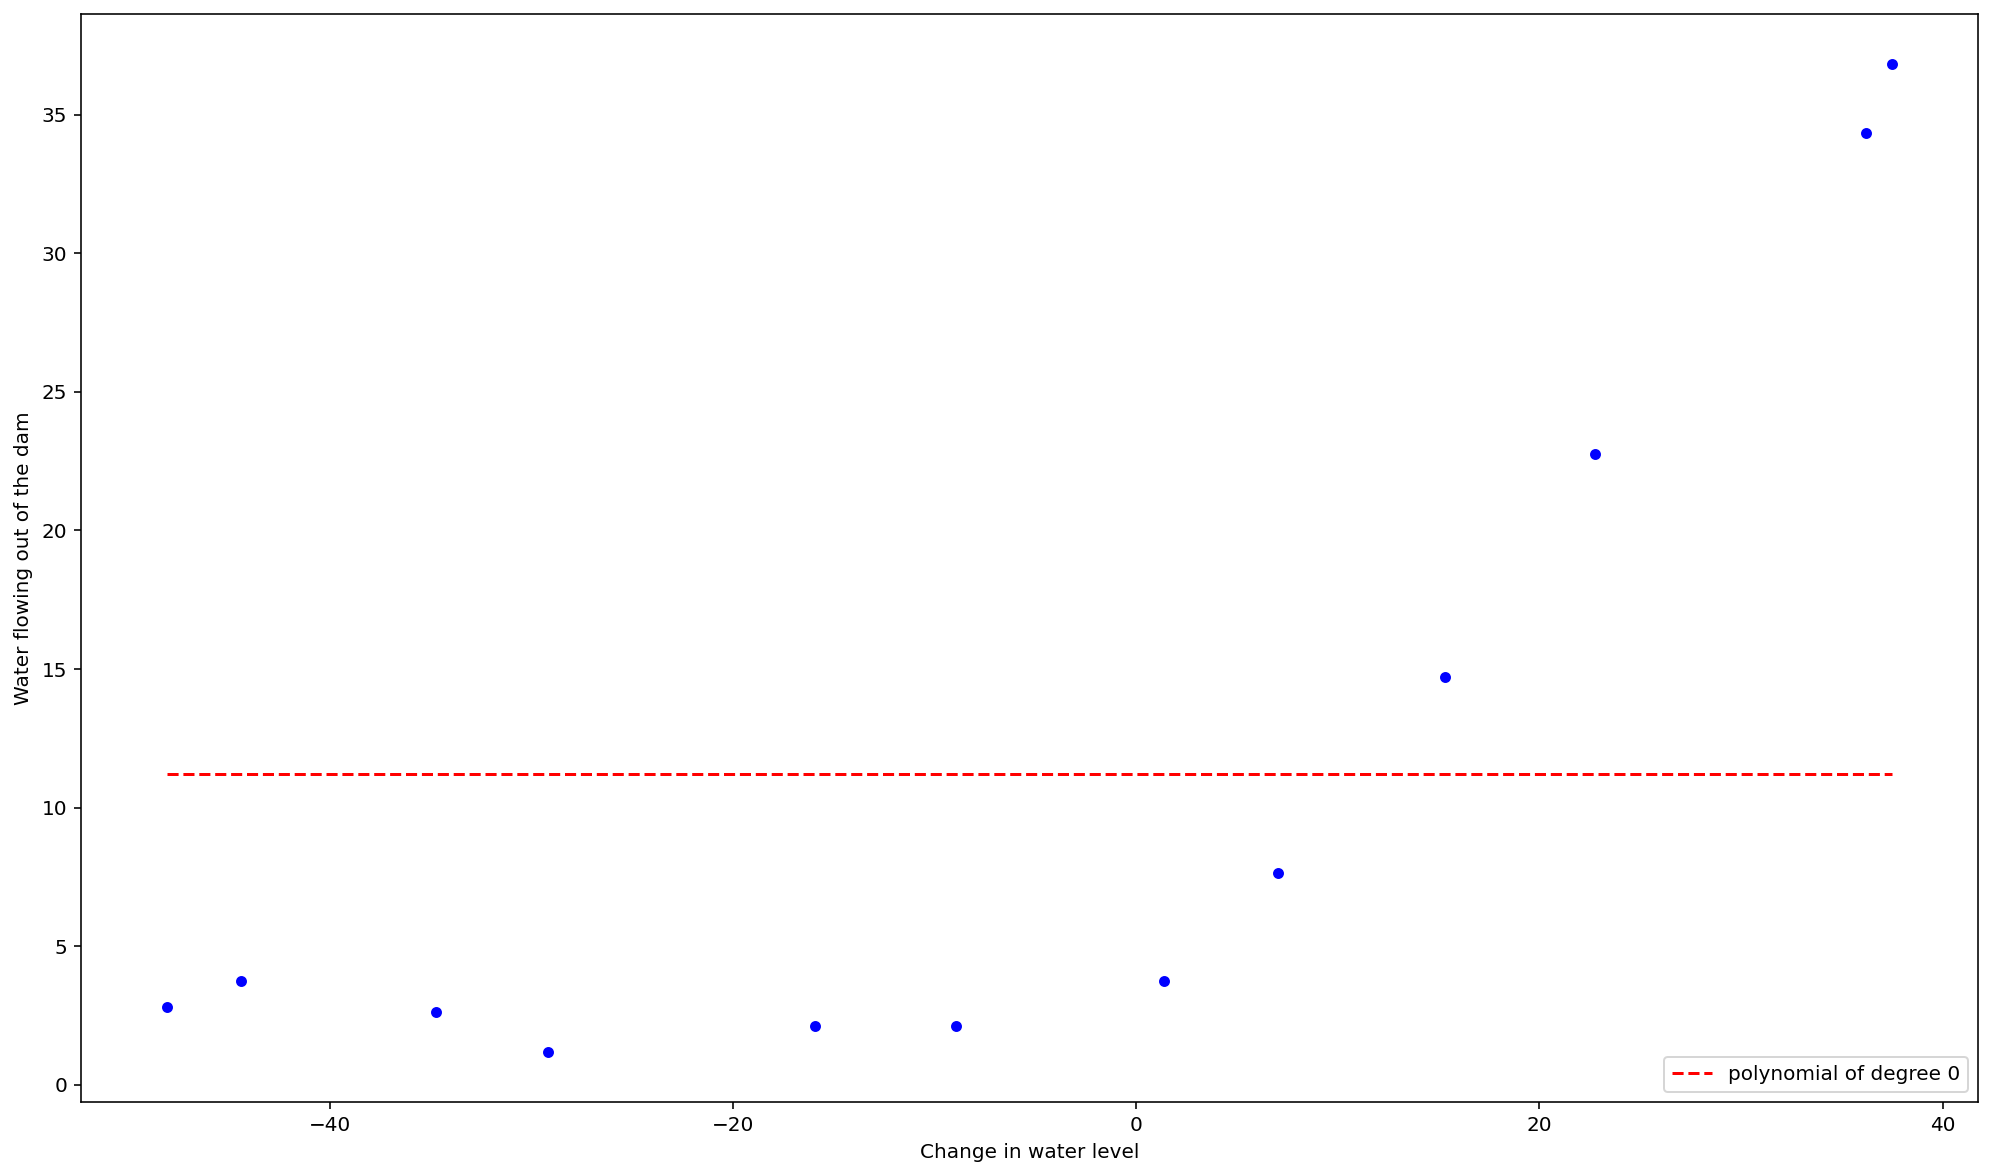

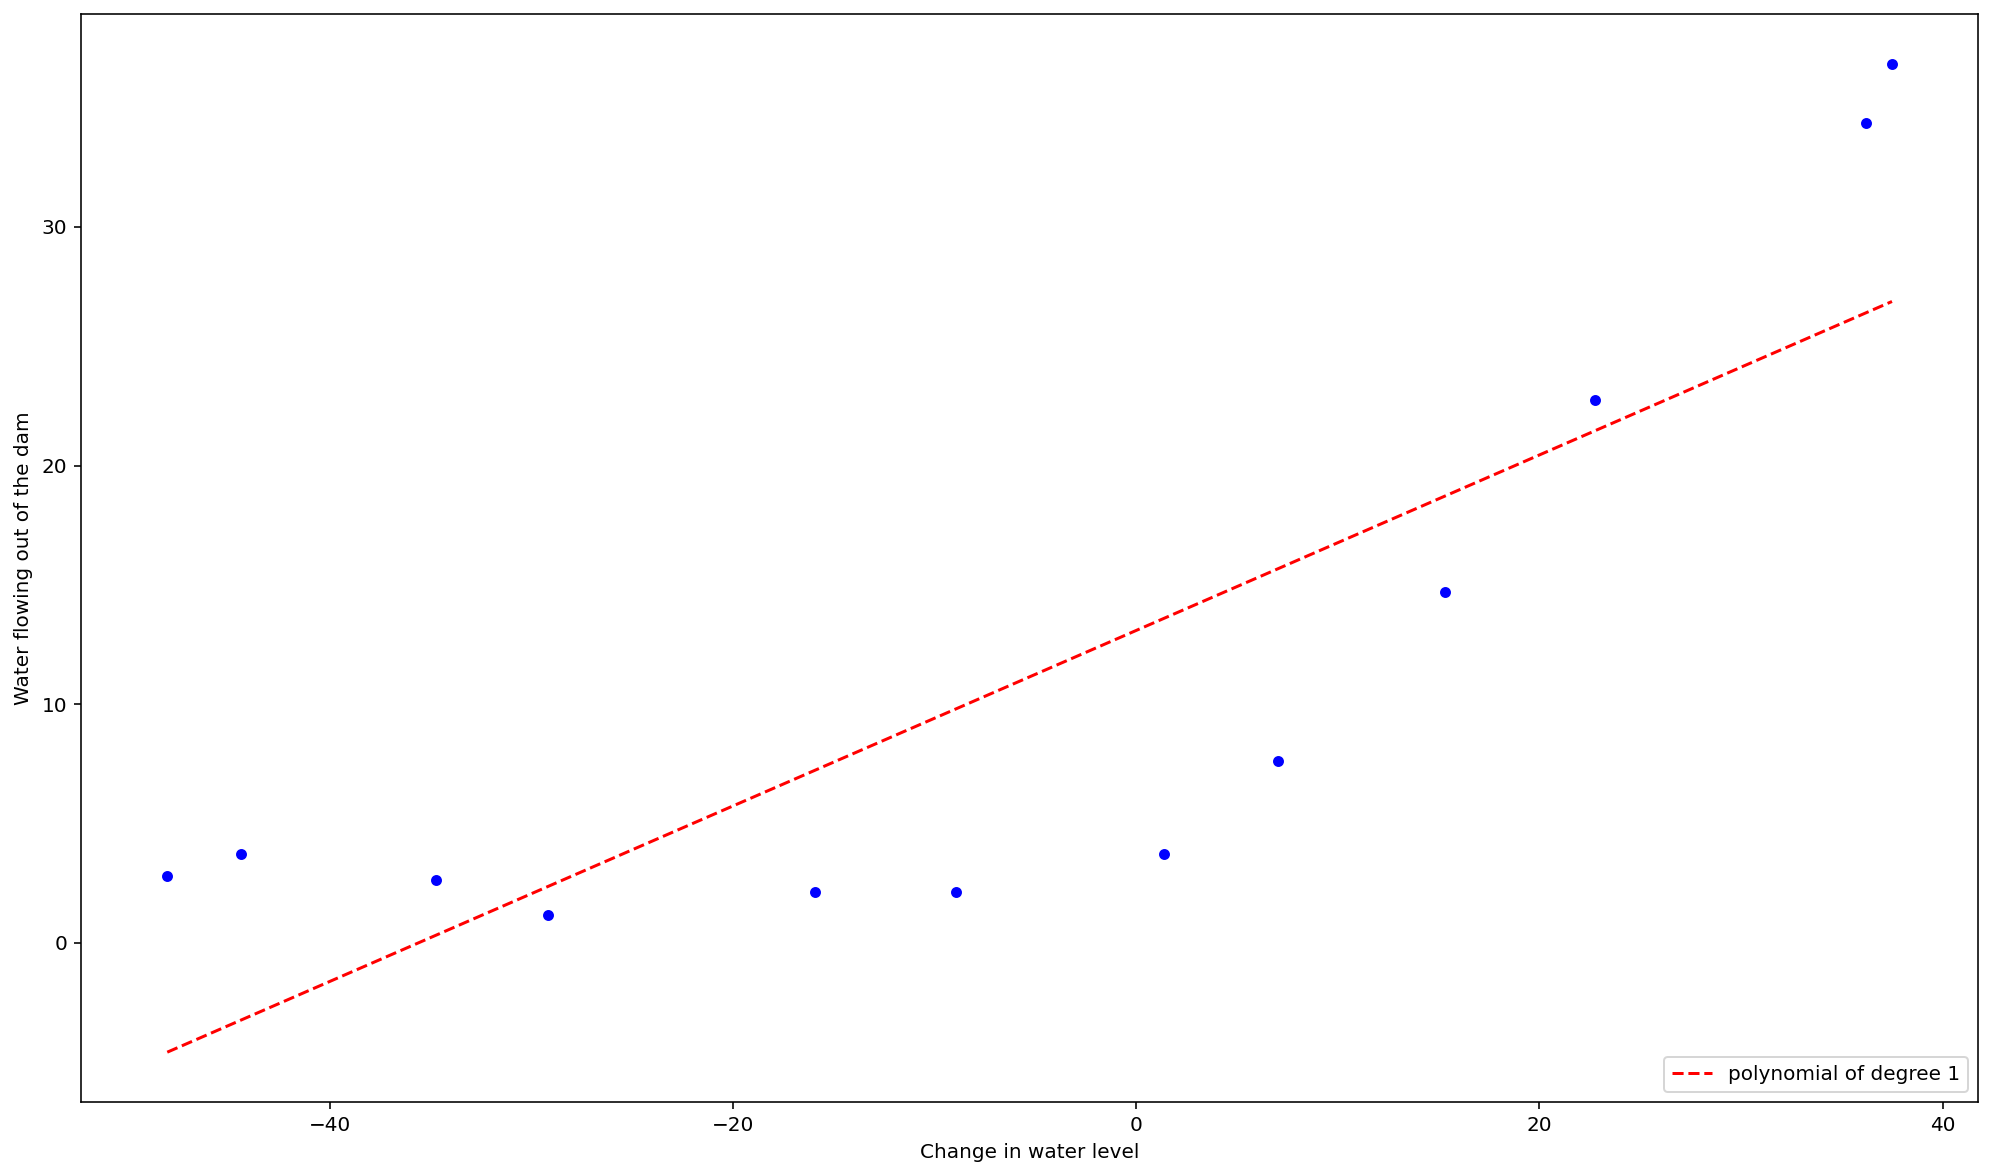

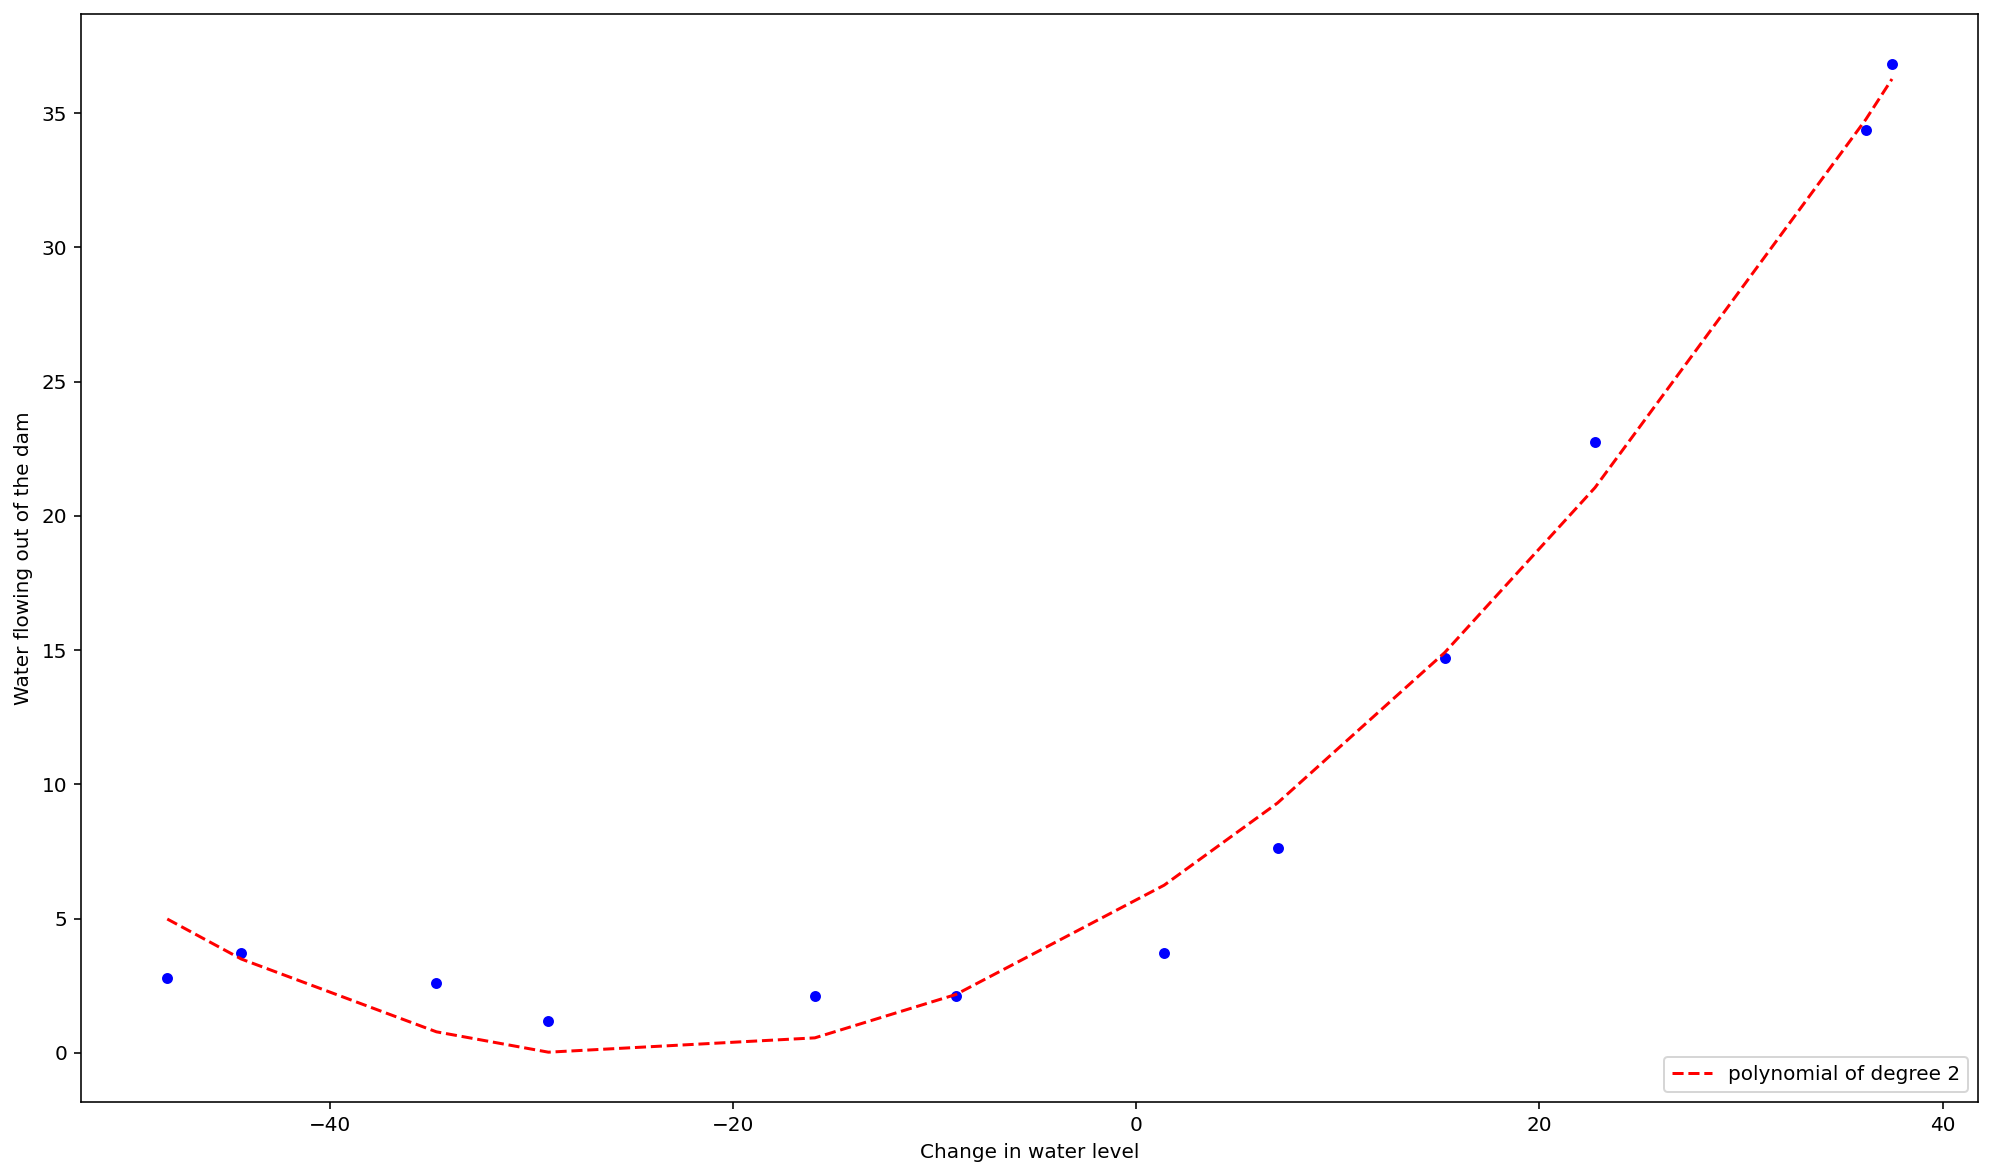

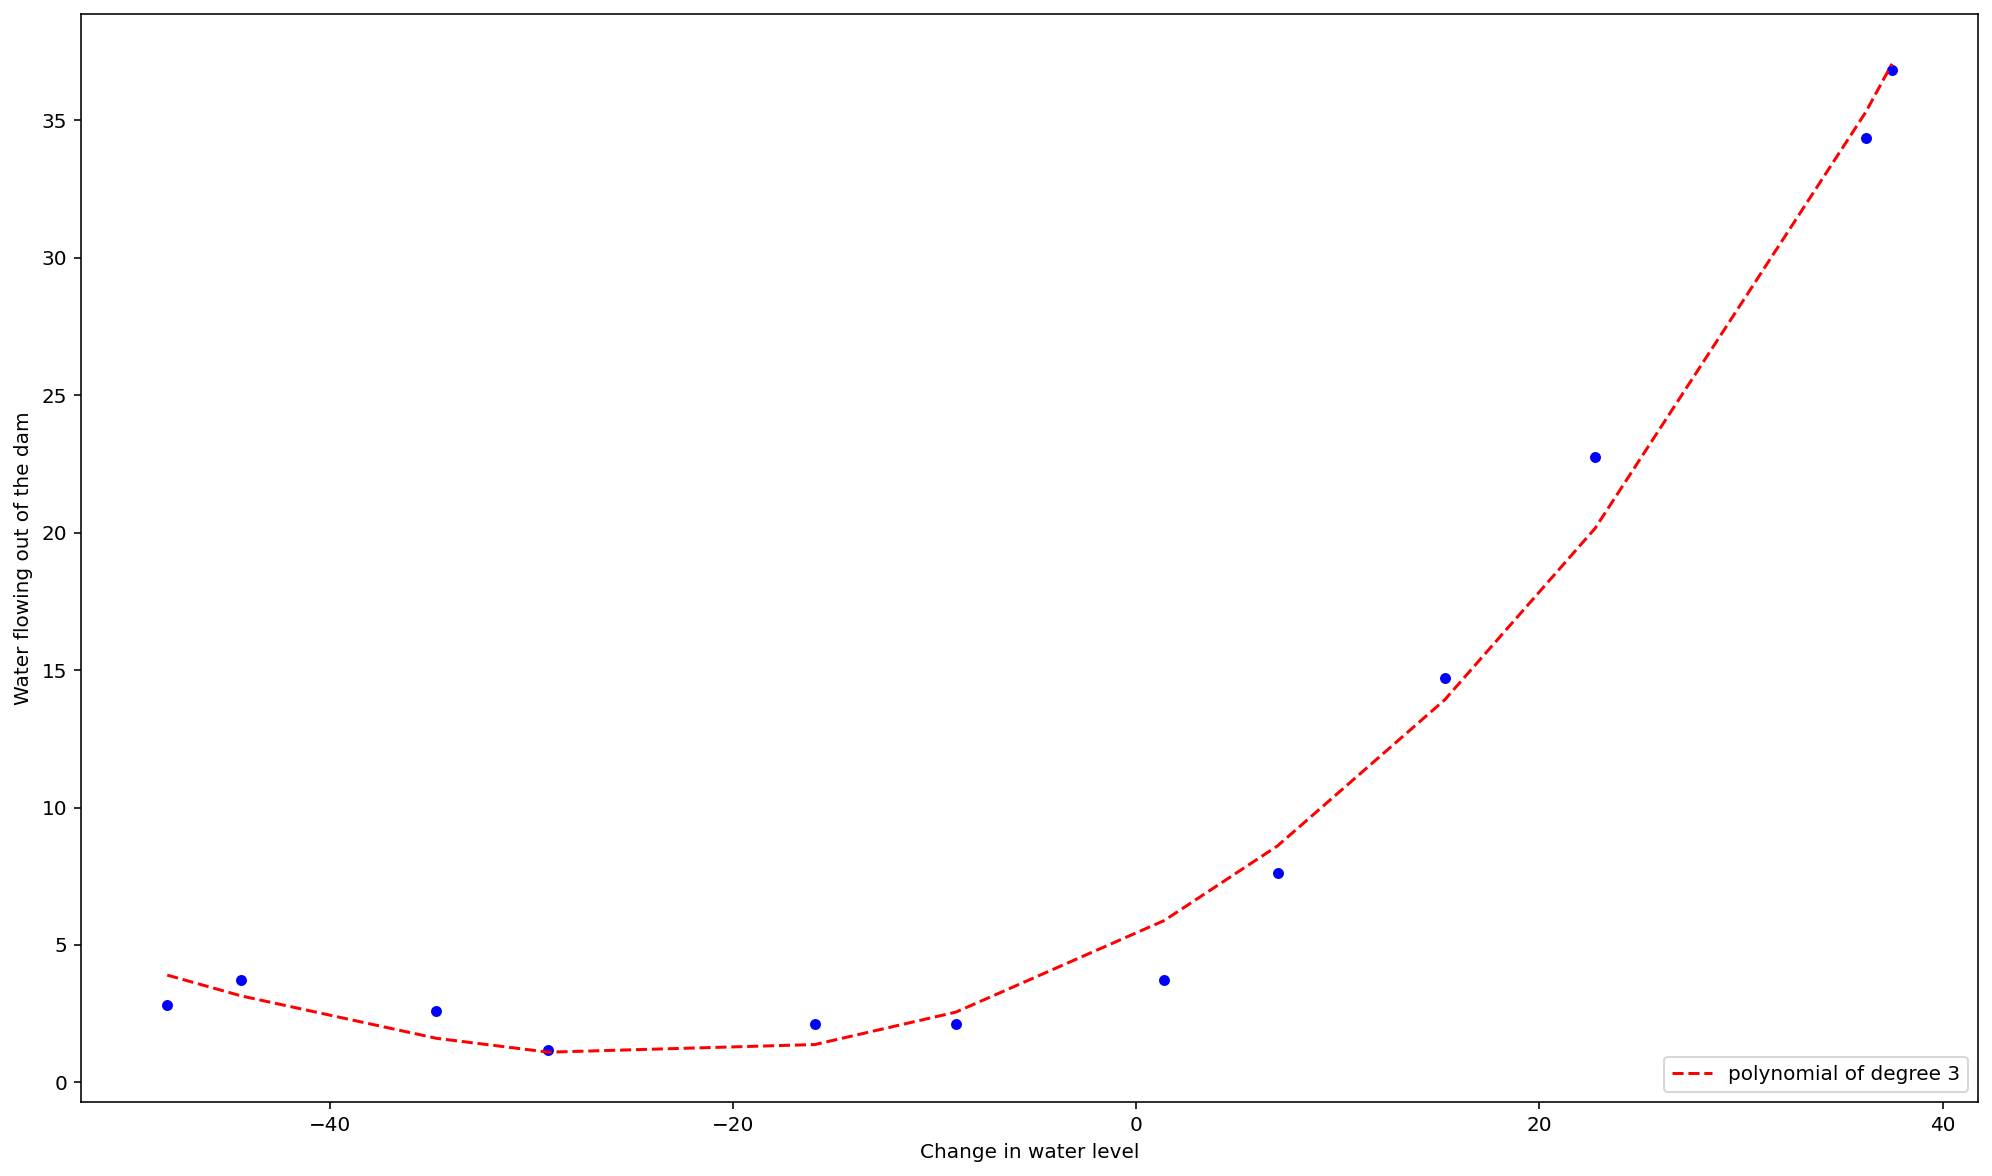

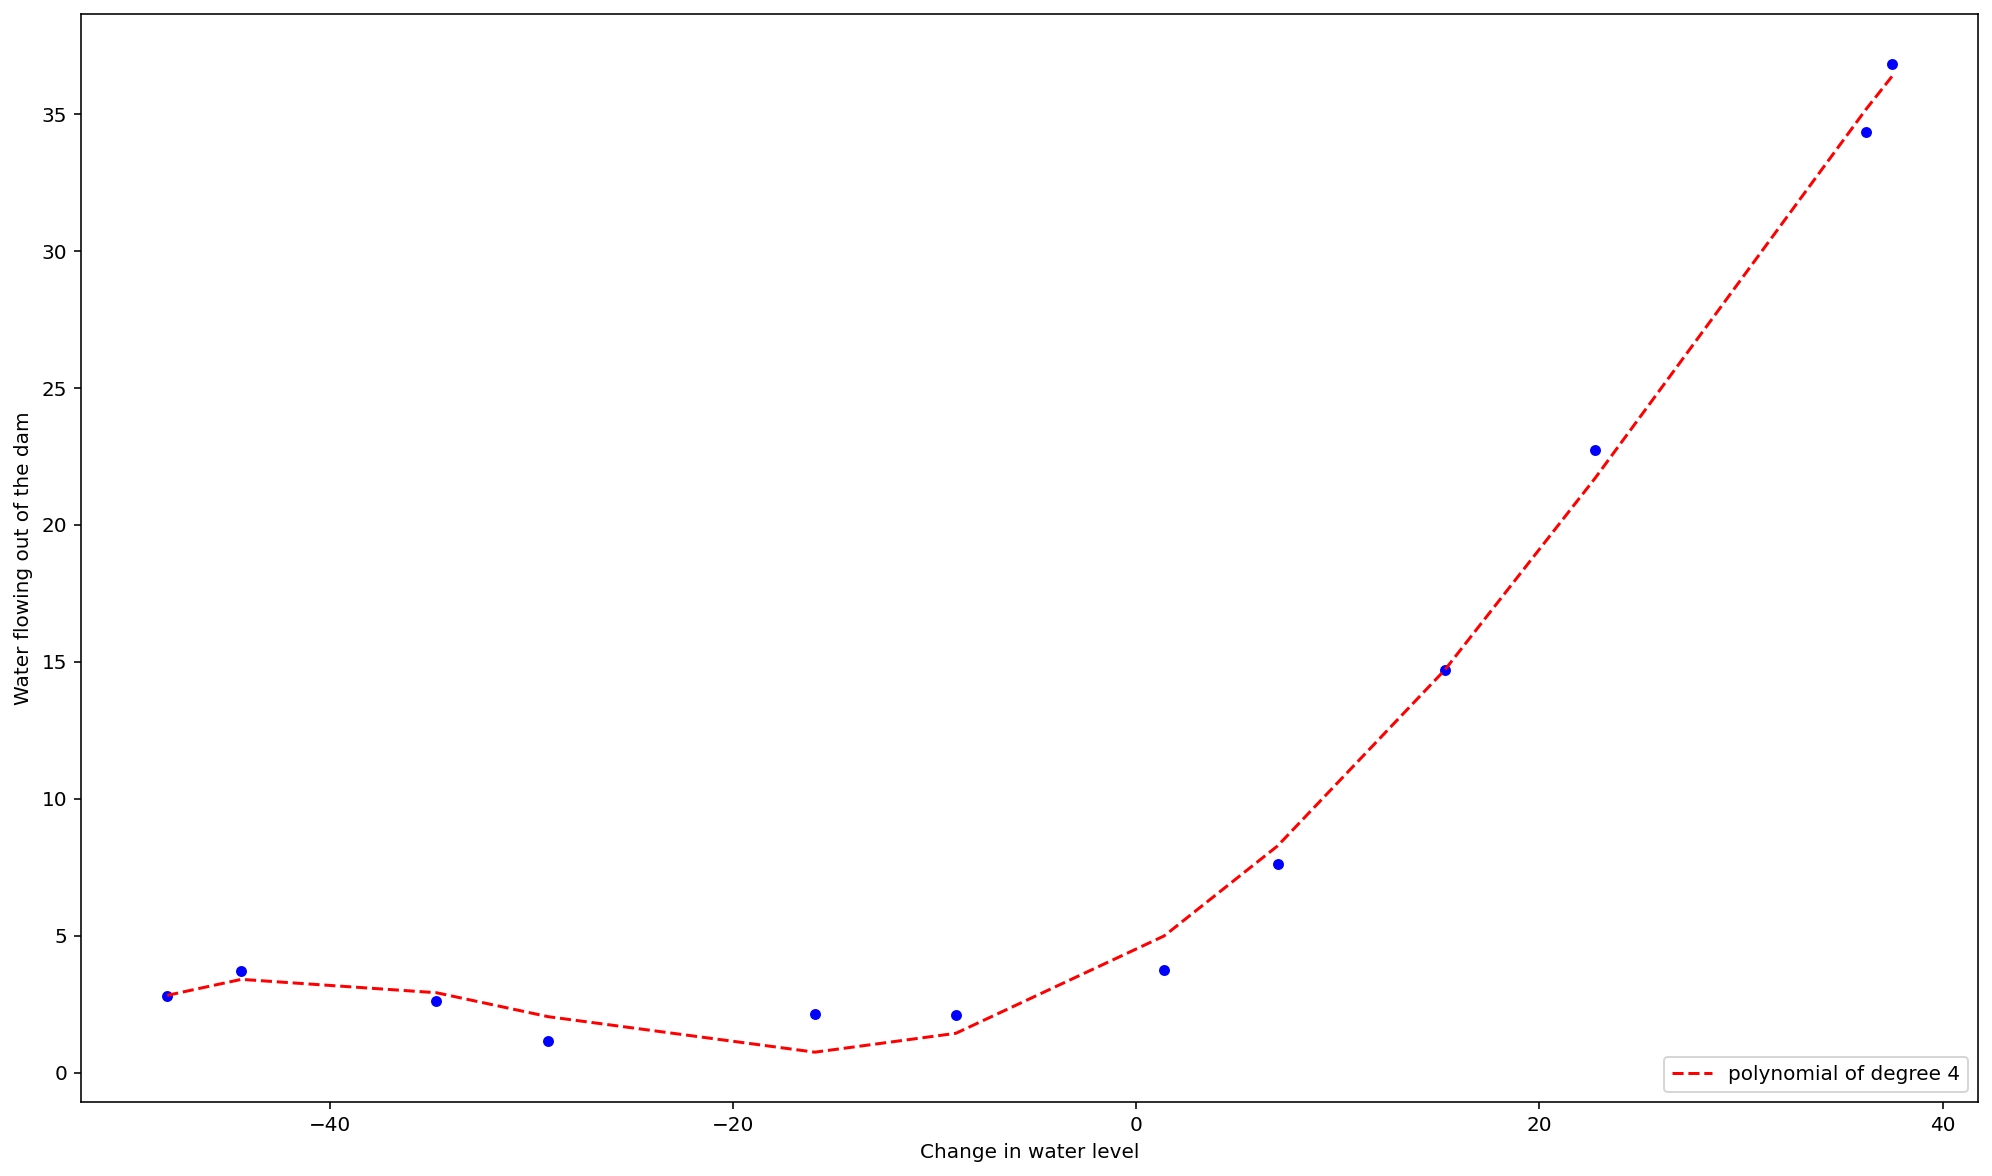

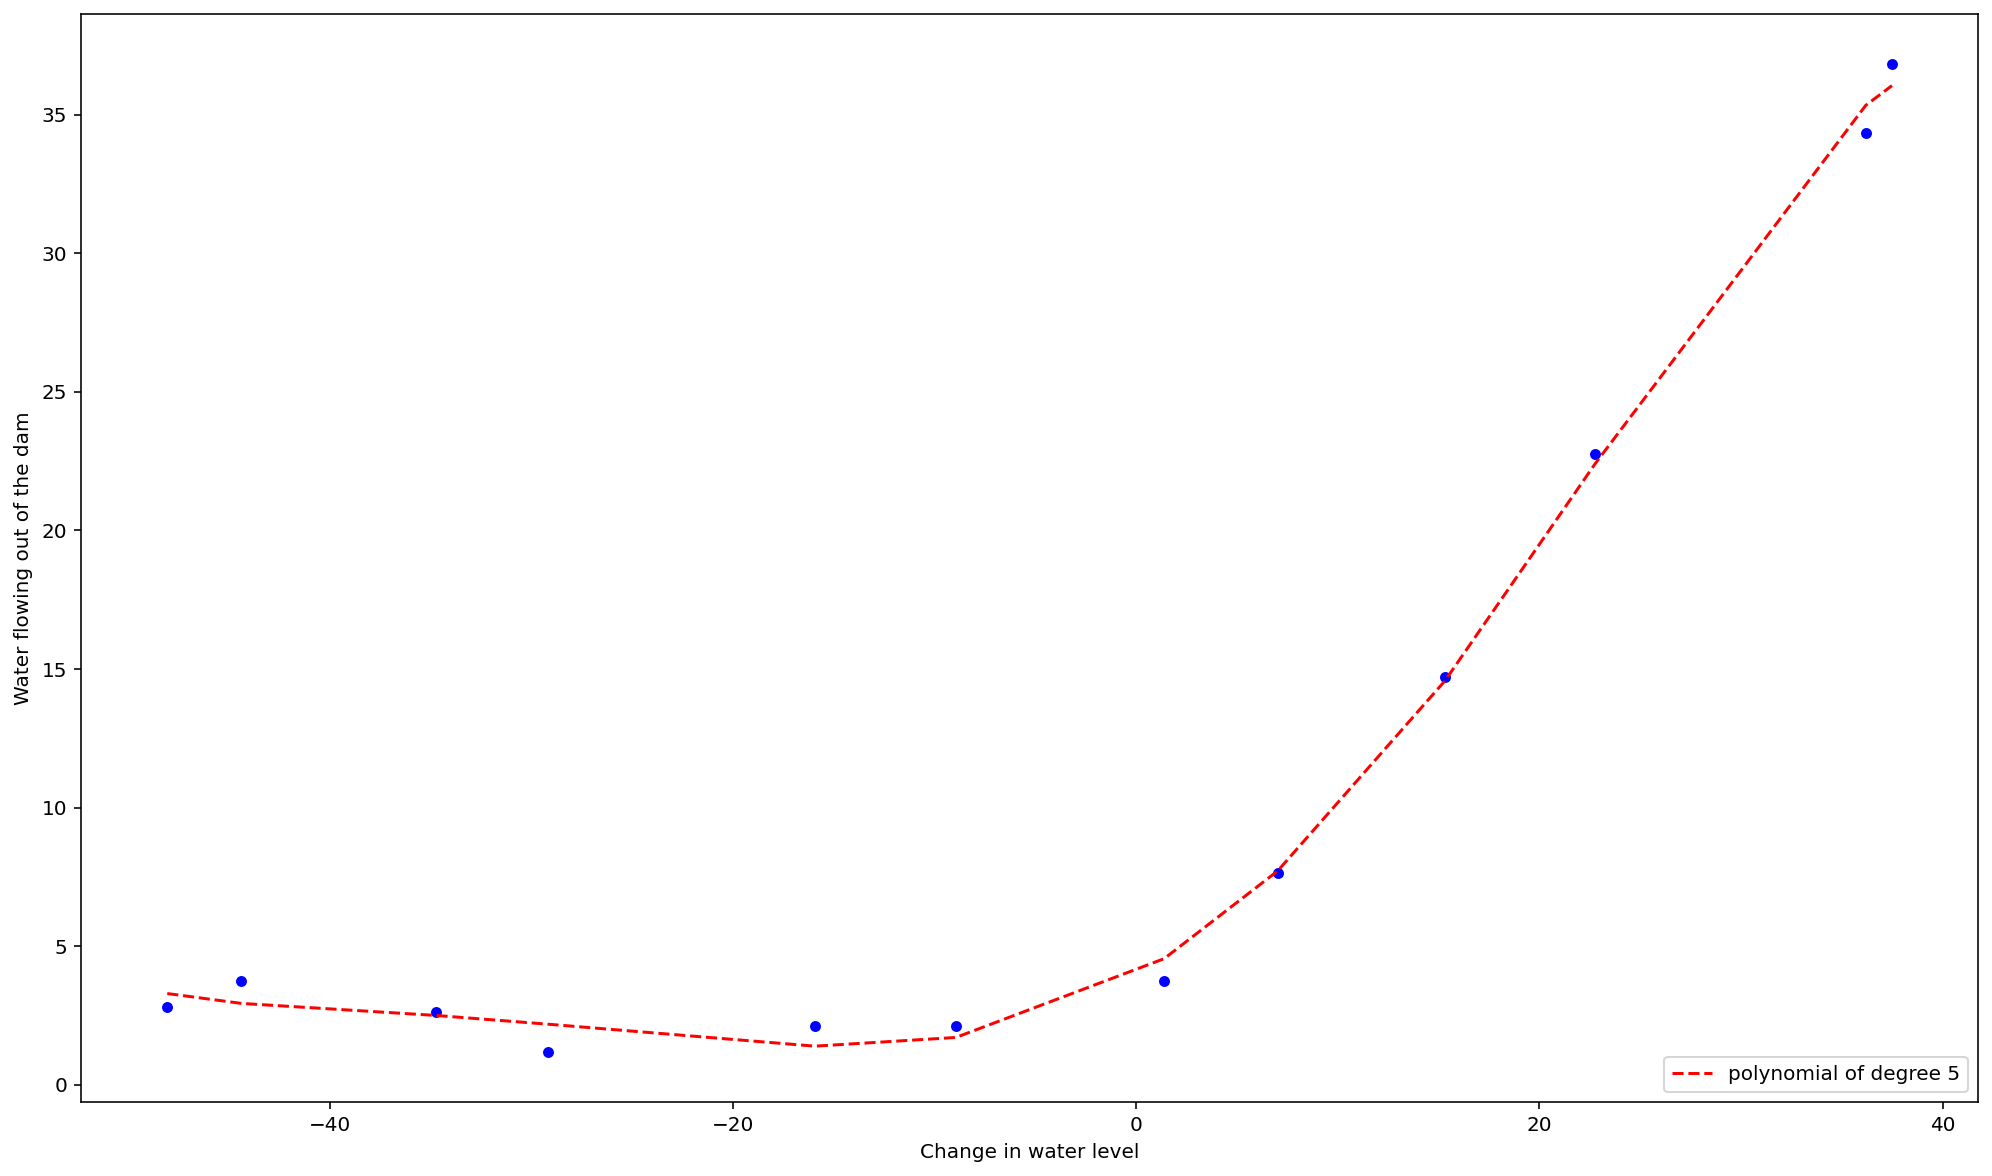

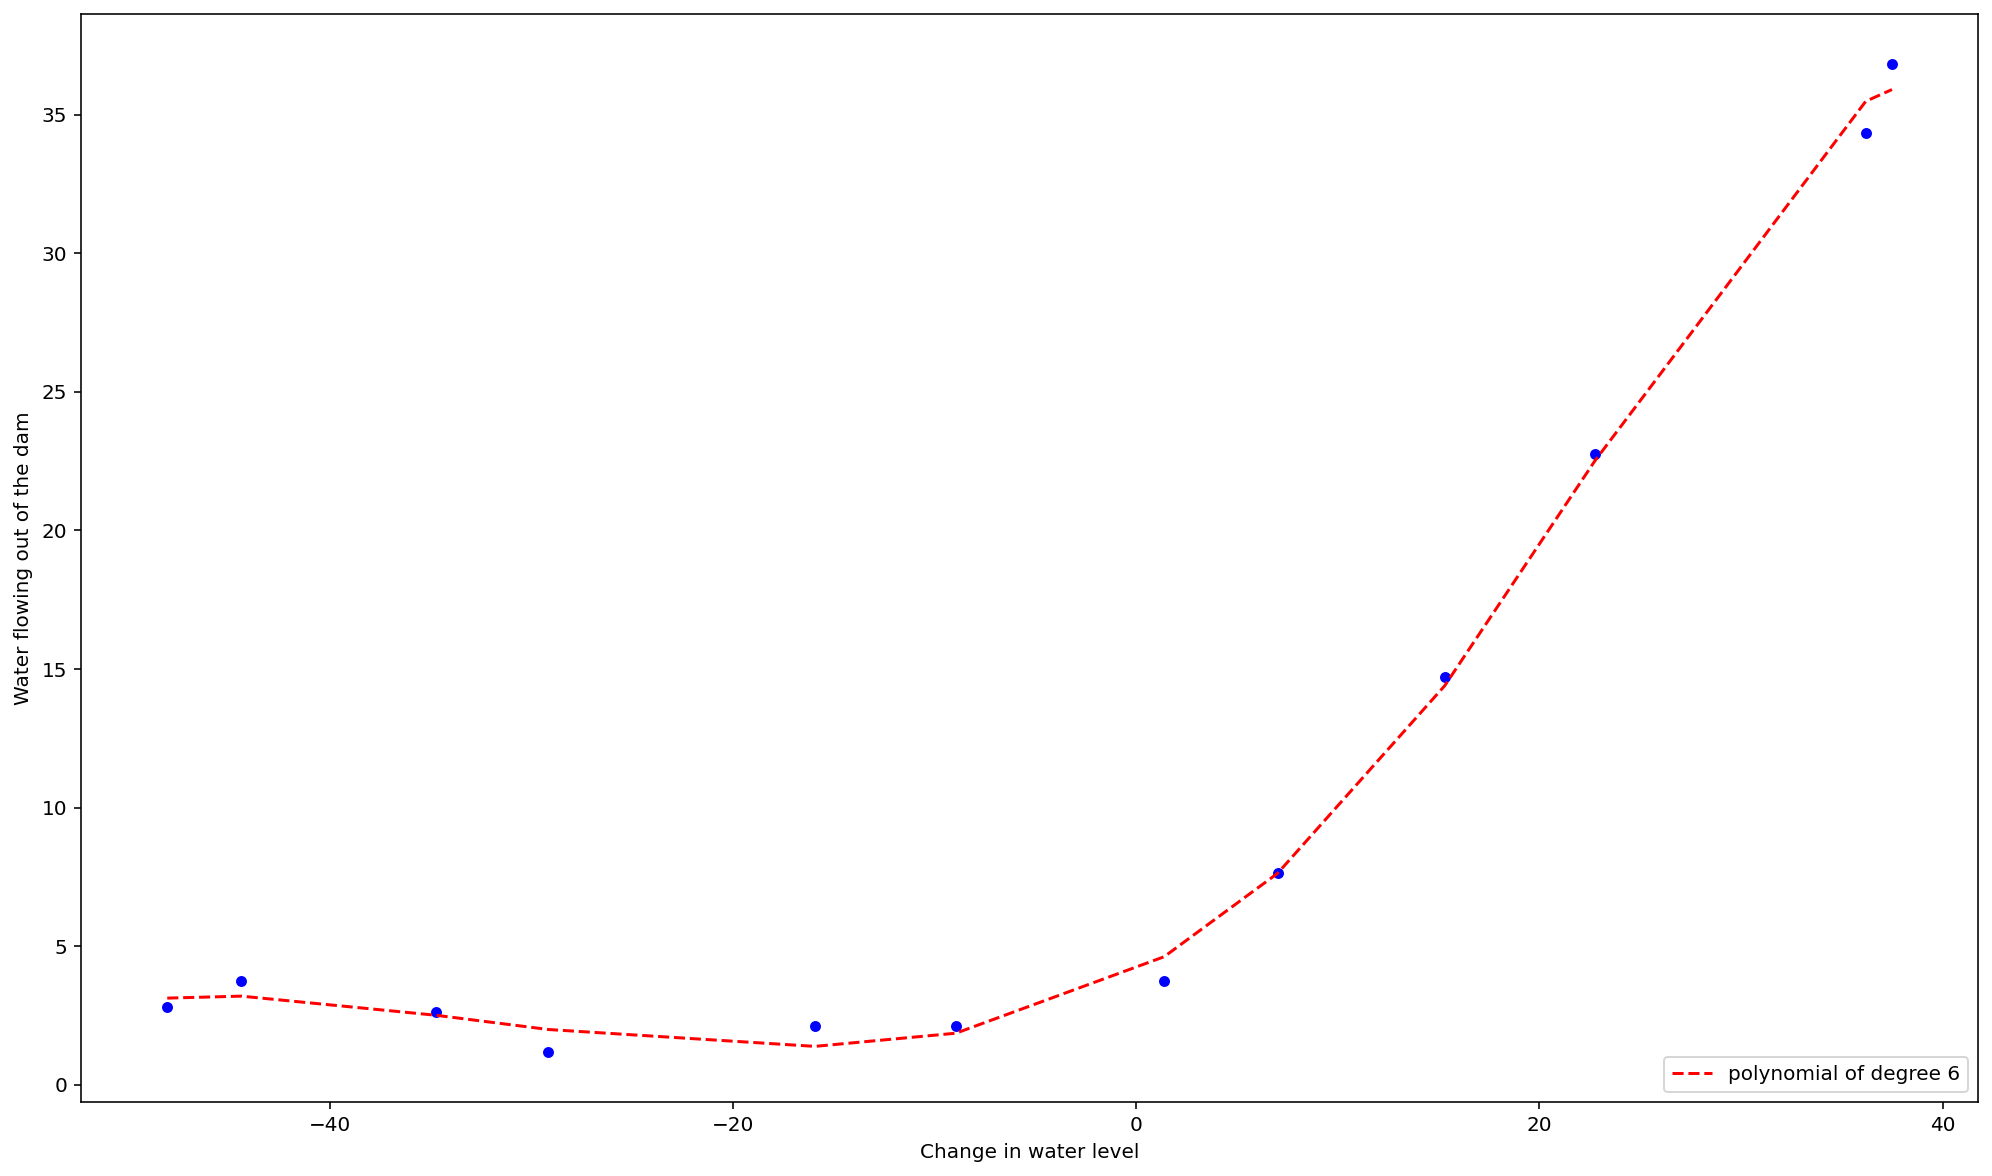

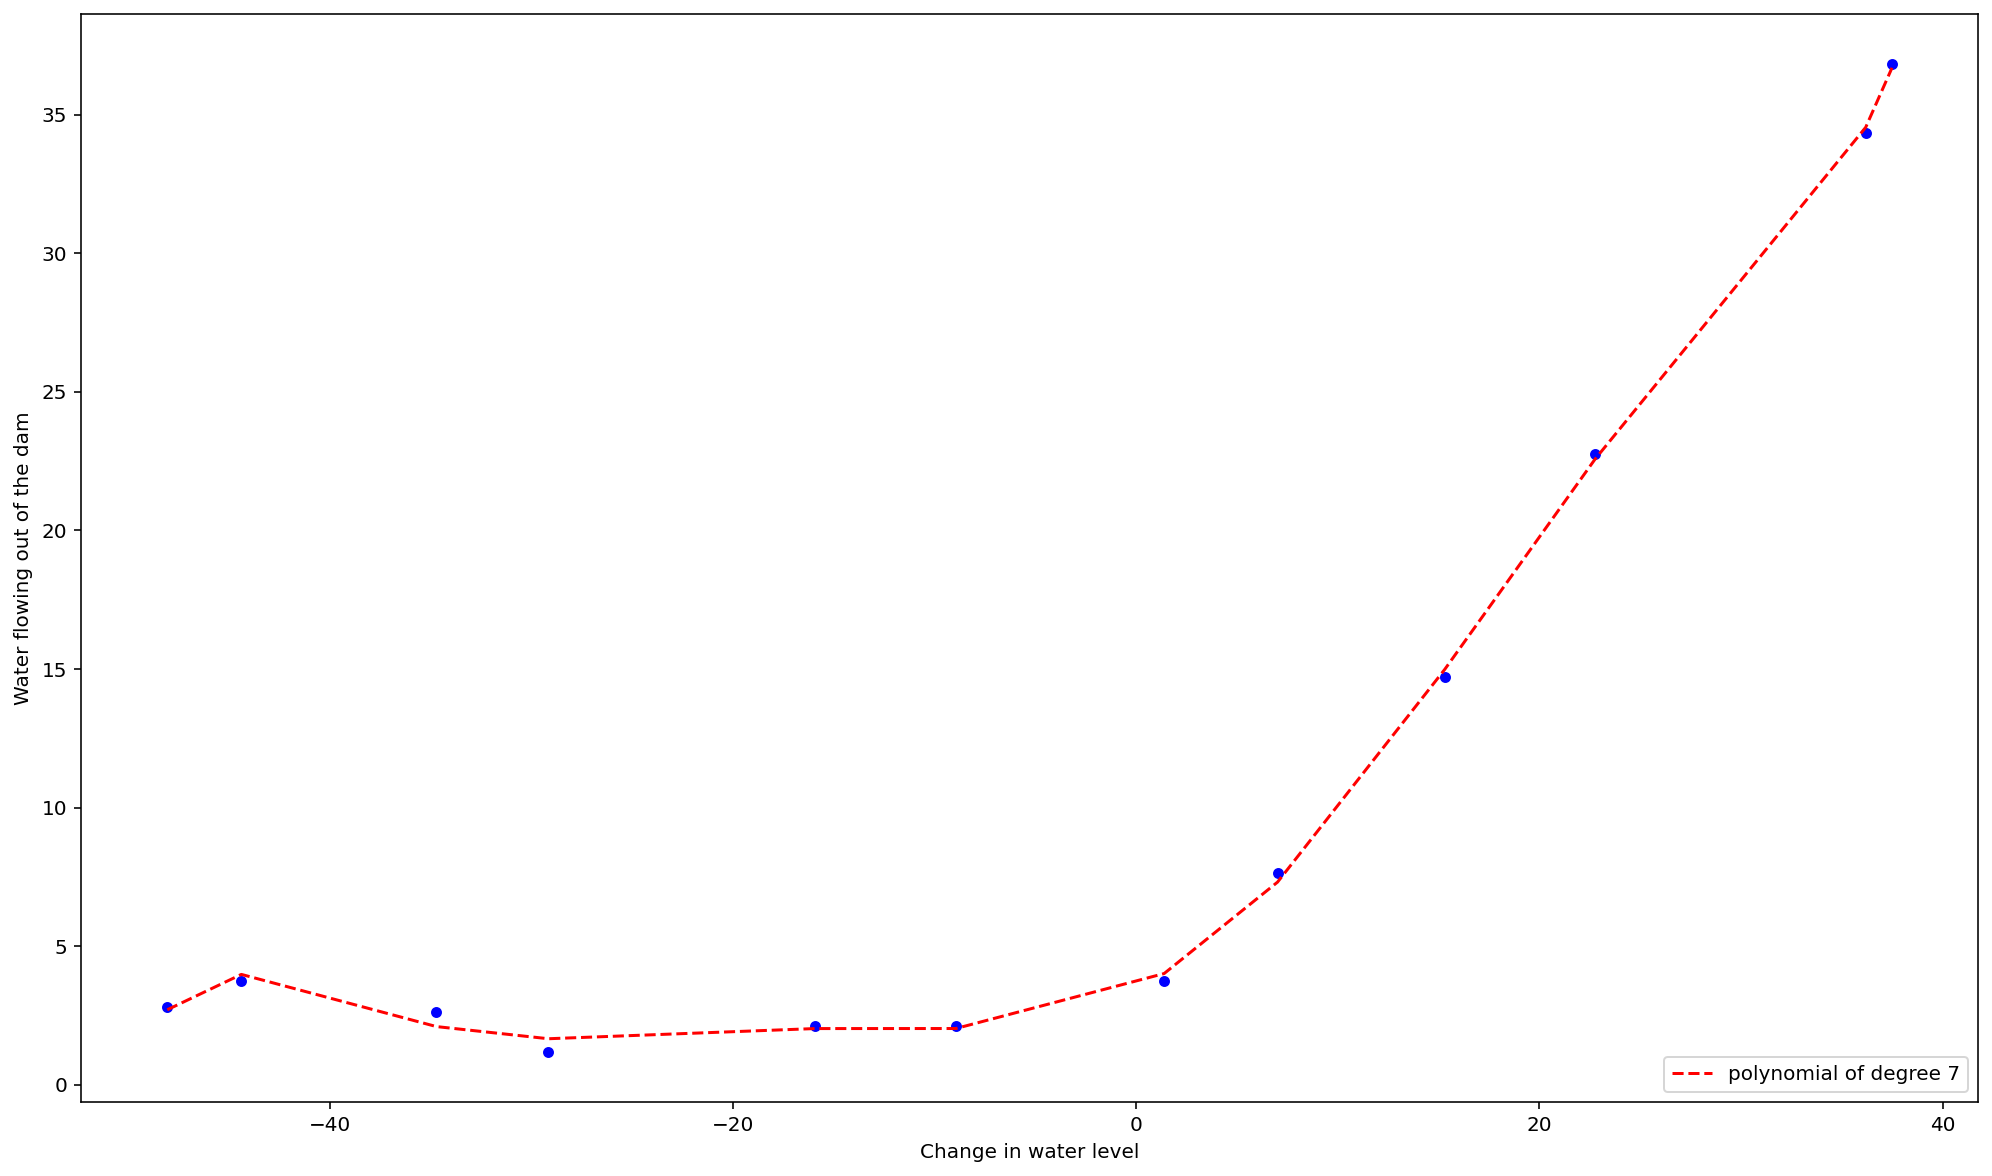

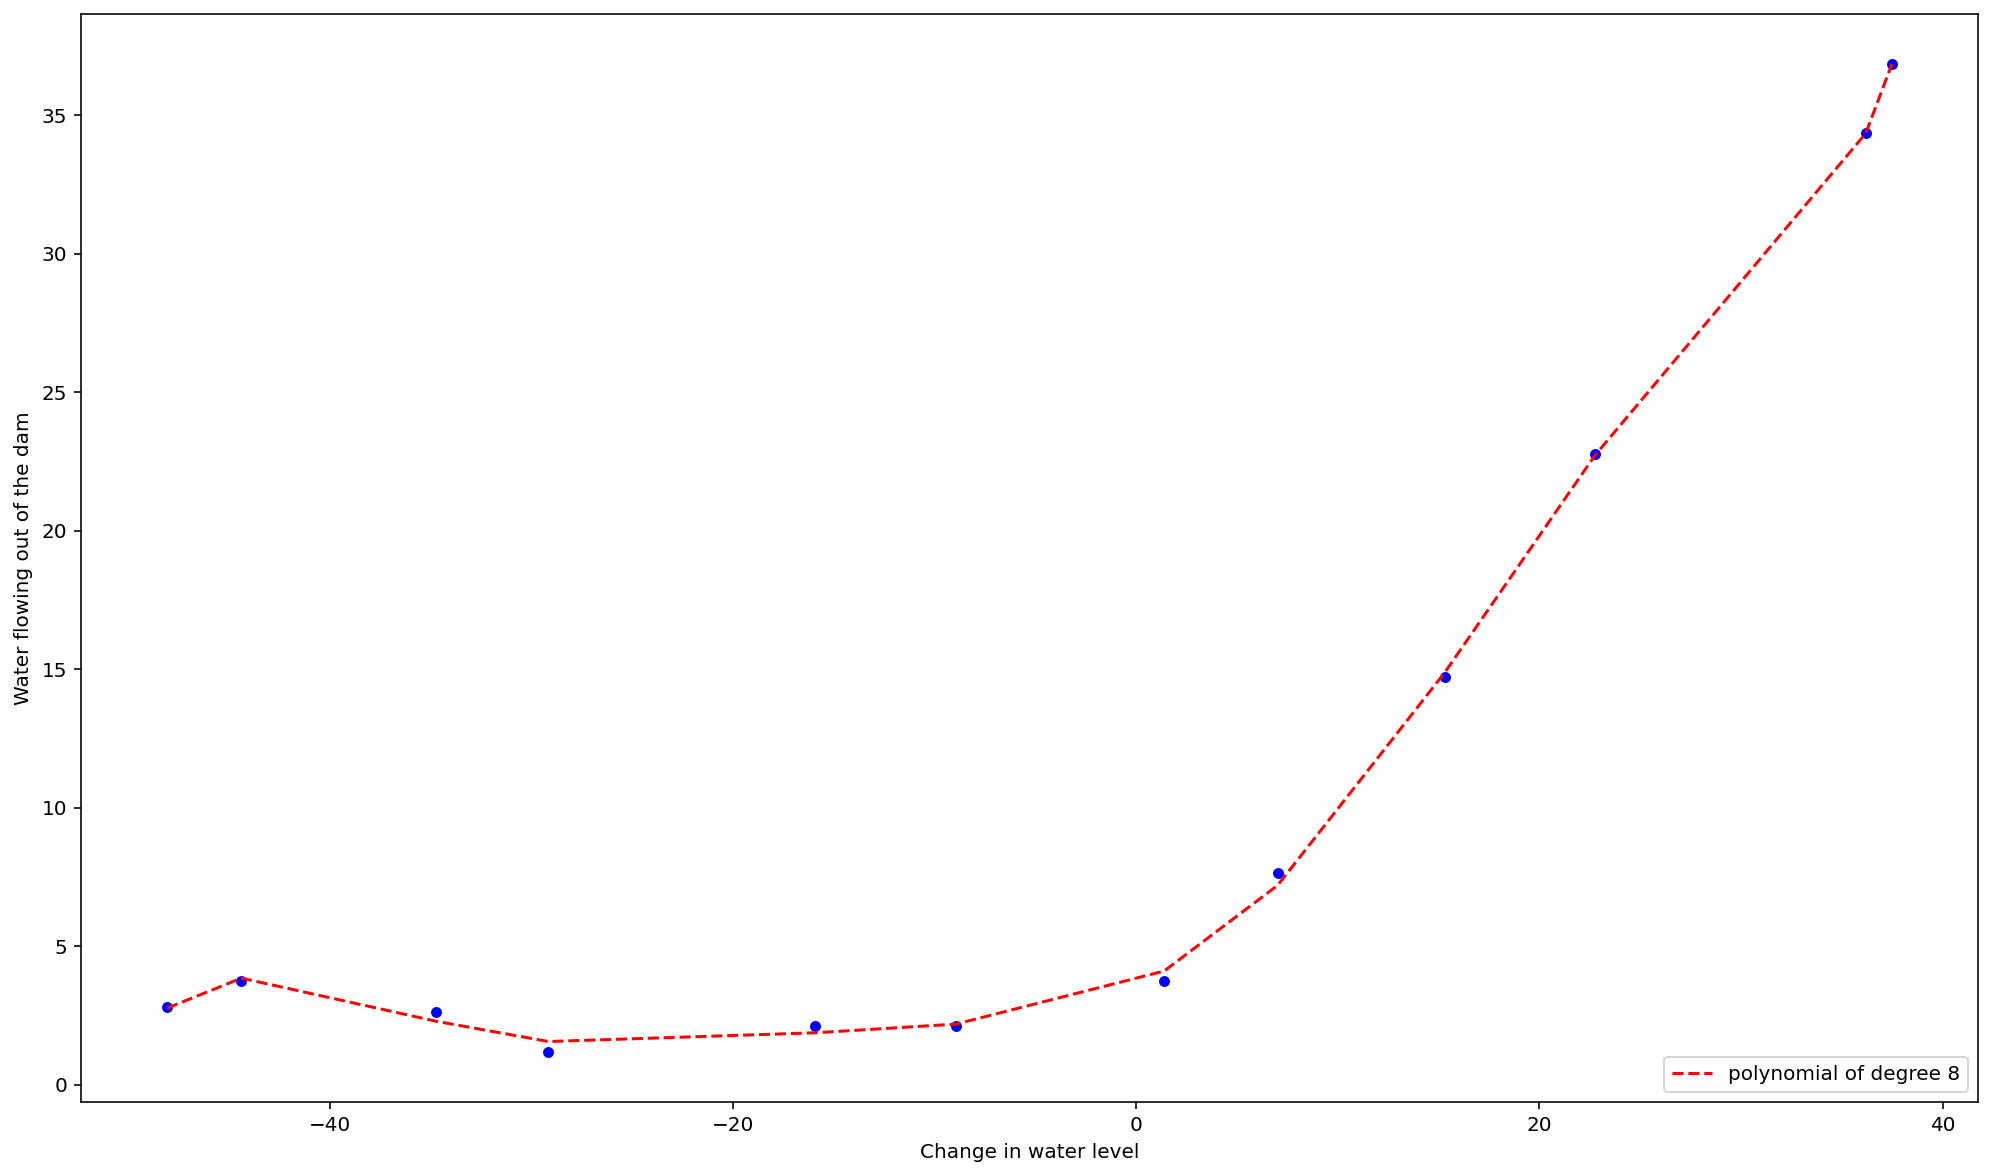

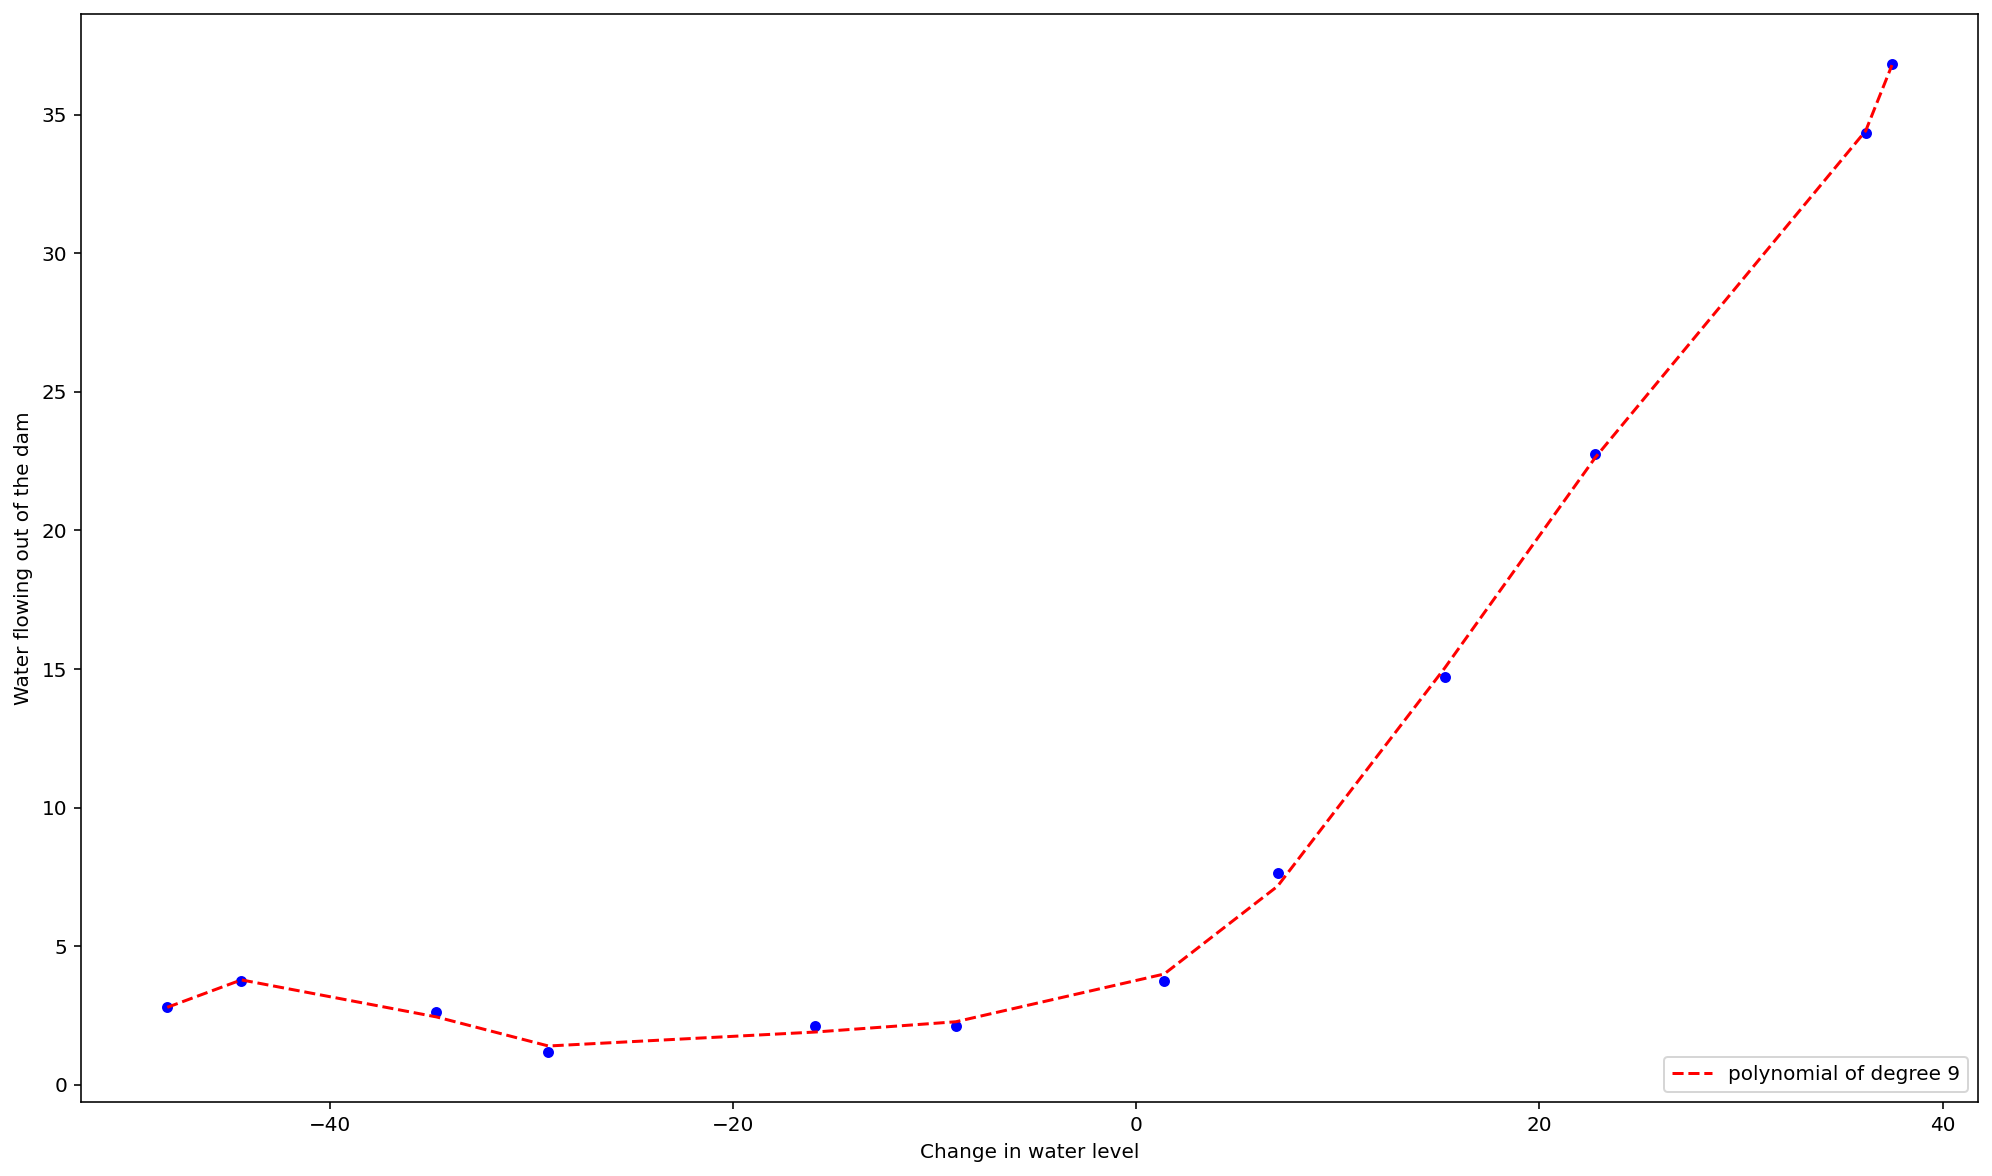

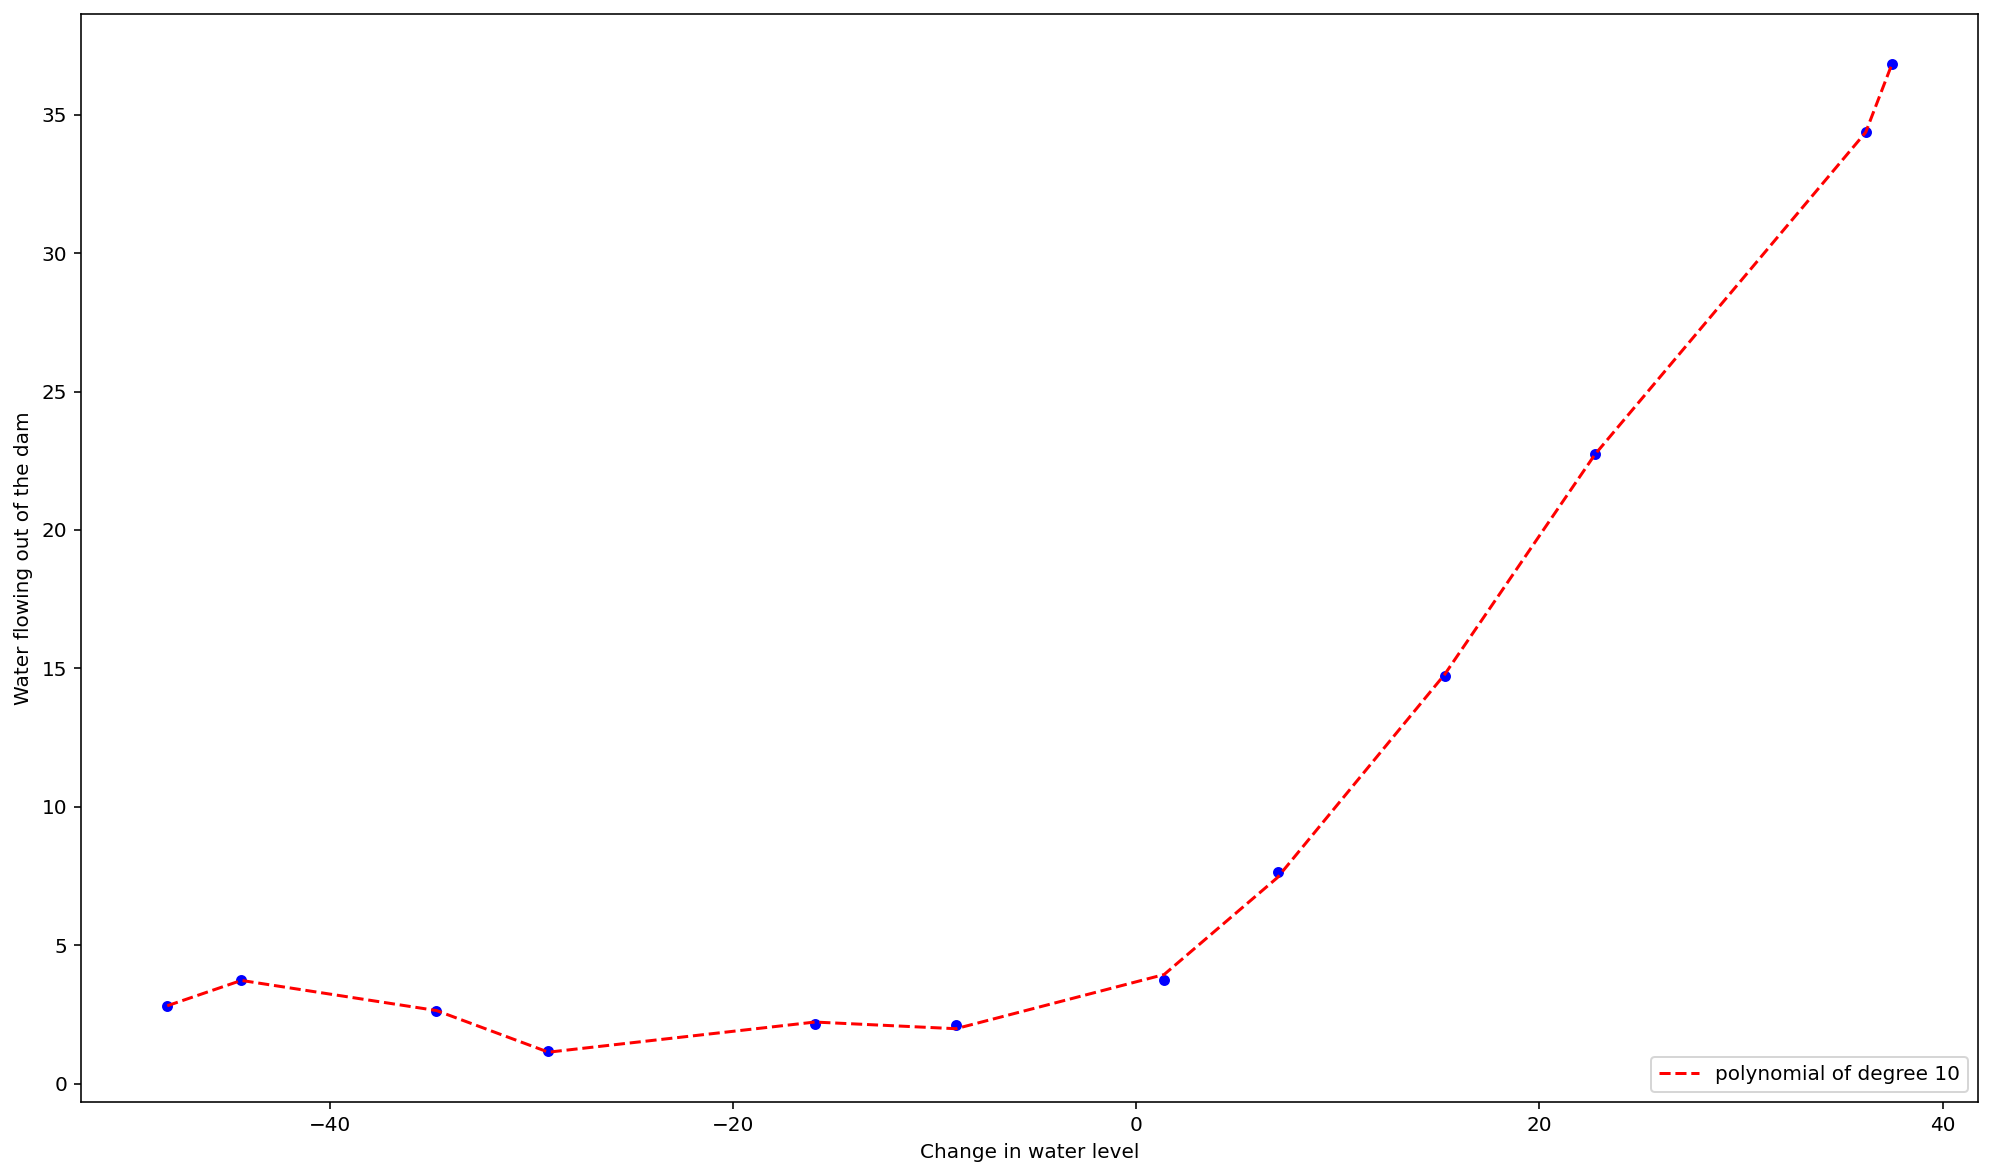

In [8]:
plot_poly(x, y, xlabel, ylabel)

## Overfitting

Now we want to answer the question of finding the _best_ fit.

A naive answer might be the polynomial of order $10$ since it perfectly pass through all the points of the dataset.

However, one can immediately show how this poorly performs on predictions.

We now use `PolynomialFeatures` from `sklearn.preprocessing` to prepare data and `LinearRegression` to make predictions.

In [9]:
level_test = 25

x = np.array(x)
poly = PolynomialFeatures(10)
X_ = poly.fit_transform(x.reshape(-1,1))
level_test_array = poly.fit_transform(np.array(level_test).reshape(1,-1))

In [10]:
model = LinearRegression()
model.fit(X_, y);

We can now make predictions on our `level_test`.

In [11]:
prediction = model.predict(level_test_array)

print('Your predicted flow: %.10f' %prediction)
print('You should get approximatively: 22.32')

Your predicted flow: 23.6274419149
You should get approximatively: 22.32


Not really satisfying.

The situation gets even worst when the test point falls out of the initial data range.

In [12]:
level_test2 = 100
level_test2_array = poly.fit_transform(np.array(level_test2).reshape(1,-1))

In [13]:
prediction2 = model.predict(level_test2_array)

print('Your predicted flow: %.10f' %prediction2)
print('You should get approximatively: 49.86')

Your predicted flow: -2210841.6533988966
You should get approximatively: 49.86


Here the answer is completely wrong!

Let's explore the reasons a bit more.

First of all, we can plot in a bit wider range the ten-degree polynomial and the three-degree one.

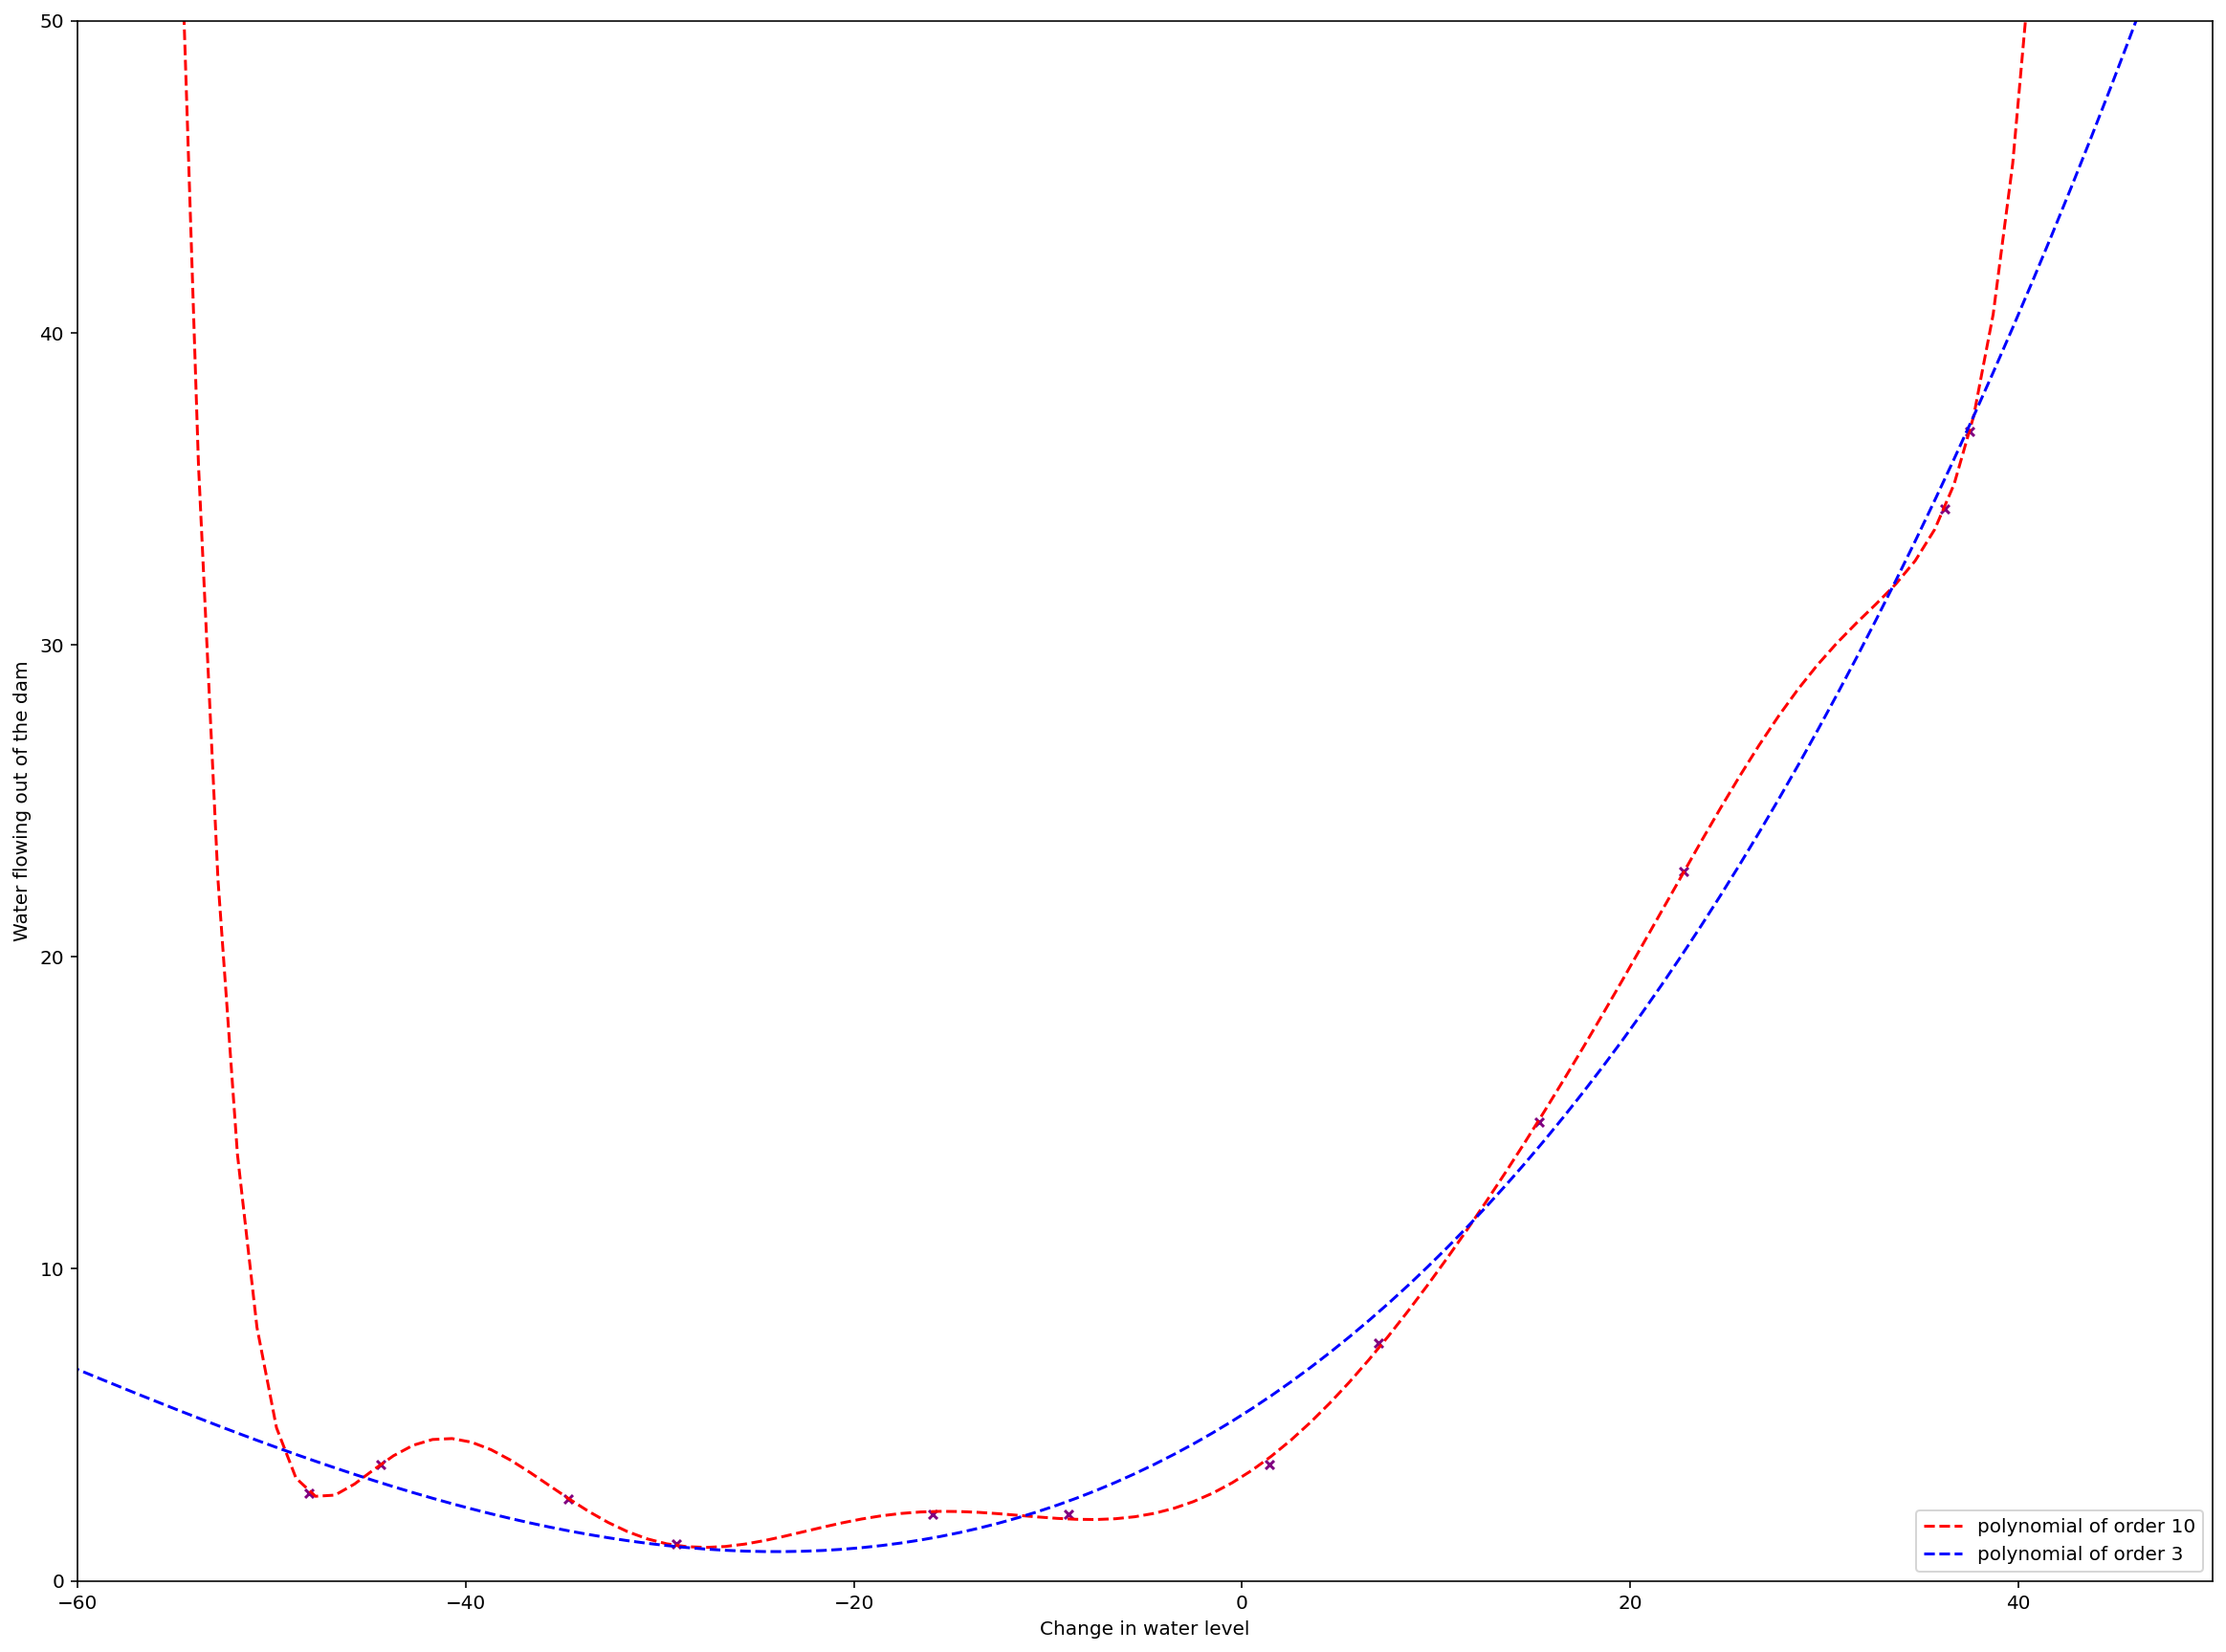

In [14]:
measures.plot(kind='scatter', x = xlabel, y = ylabel, marker = 'x', color='purple', figsize=(20,15))
xx = np.linspace(start=-100, stop=100, num=200)
z10 = np.polyfit(x, y, 10)
p = np.poly1d(z10)
plt.plot(xx, p(xx), "r--", label = 'polynomial of order 10')
z3 = np.polyfit(x, y, 3)
p = np.poly1d(z3)
plt.plot(xx, p(xx), "b--", label = 'polynomial of order 3')
plt.xlim(-60, 50)
plt.ylim(0,50)
pst = plt.legend(loc='lower right', frameon=True)

As you can see, the red line perfectly pass trough all the points, however, it loses the property of being generalisable on new data points.
This issue is something typical in statistical procedures and when one handles a dataset describing complex situations (_i.e._ with a lot of features) and it is commonly known under the name of __overfitting__.

To give a more precise definition of overfitting, one can say

> __Overfitting__ is the production of an analysis that corresponds too closely or exactly to a particular set of data, and may therefore fail to fit further additional data or predict future observations reliably.

> An __overfitted model__ is a statistical model that contains more parameters than can be justified by the data.

A lot of wordy descriptions have been given of overfitting. 
Here we report two just for the sake of memory.

1. An __overfitted model__ is a model that is too complex for the data.
2. An __overfitted model__ does not _learn_, it _remembers_.

<p align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/600px-Overfitting.svg.png">
</p>

In our polynomial example, we have more (or a comparable number of) coefficients to estimate than data points.

Indeed, in the case above, we had to predict $11$ coefficients (for a ten-degree polynomial) with $12$ data points.
Indeed, if we try a polynomial of order $12$ for instance, python will give us a warning.

In [15]:
z = np.polyfit(x, y, 12)

/Users/oscardefelice/miniconda3/envs/lectures/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


### Fighting overfitting

Now the question any data scientist wanders:

> How do we face such an issue?

Well, we have several possibilities:

1. Reduce the number of parameters, _i.e._ the number of features
2. Use a bigger dataset
3. Use a different fit function

The first one is saying "_simplify your model_", the second one "_get more information, as your model needs more to fit all his parameters_" while the third one "_change your approach_".

Note that the points `1.` and `3.` can be implemented easily, on the other hand, the point `2.` is not always easy to adopt. 
Furthermore, it might be not always a good idea to take new data, even ignoring all the issues related to data access, data costs, etc.

Even when we know how to fix this issue, we still ignore how to dectect it.
Just to rephrase, we do not know which one is the _right_ polynomial fit to use, if one exists.

We need a measure of the wellness of the fit, and this cannot be the cost function on the training dataset, since using this will lead to the overfit and to a loss of generalisation power.

In general, methods to fight overfitting are called _regularisation methods_. 
Here, we present two versions of the same regularisation method called _penalty_.

#### Ridge and Lasso penalty

The core idea of penalty methods is to add a term to the cost function such that during training, making a weight grow too much (hence adapt too much to data) would cost an higher error
Hence this behaviour is _penalised_.

Depending on the chose of such penalty term, we have _Ridge_, _Lasso_ or $L_p$ penalty.

#### Lasso regression

A model that uses $L_1$ regularization technique is called Lasso Regression, meaning it adds the “_absolute value of magnitude_” of coefficients as penalty term to the loss function.

$$ \mathcal{L} = \sum_i \left(y_i - h_{\beta}(x_i)\right)^2 + \lambda \sum \vert \beta_k \vert \, . $$

Here $\lambda$ is a regularisation parameter that tunes the magnitude of the regularisation.

#### Ridge regression

A model that uses $L_2$ regularisation technique is called Ridge Regression, meaning it adds the “_square value of magnitude_” of coefficients as penalty term to the loss function.

$$ \mathcal{L} = \sum_i \left(y_i - h_{\beta}(x_i)\right)^2 + \lambda \sum \Vert \beta_k \Vert^2 \, . $$

Again $\lambda$ determines how much of regularisation effect one wants.

#### $L_p$ regularisation

We can use the form we want for the penalty term to the loss function.
A particular case is the one making use of the $p$-norm.

$$ \mathcal{L} = \sum_i \left(y_i - h_{\beta}(x_i)\right)^2 + \lambda \sum \Vert \beta_k \Vert_p^p \, , $$

where 

$$ \Vert x \Vert_p := \left( \sum_i \vert x_i \vert^p \right)^{\tfrac{1}{p}}\, .$$

The key difference between these techniques is how these penalise the coefficient growth. 
For example, Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for _feature selection_ in case we have a huge number of features.

### Underfitting

In contrast to overfitting,one can imagine that when a model is underfitted it means that the model does not fit the training data and therefore misses the trends in the data. 
It also means the model cannot be generalized to new data. 
As you probably guessed (or figured out!), this is usually the result of a very simple model (not enough predictors/independent variables). 
It could also happen when, for example, we fit a linear model (like linear regression) to data that is not linear.
It almost goes without saying that this model will have poor predictive ability (on training data and cannot be generalized to other data).

<p align="center">
    <img width="900" src="https://miro.medium.com/max/1110/1*tBErXYVvTw2jSUYK7thU2A.png">
</p>

In Machine Learning literature, an underfitted model is also known as affected of _high bias_, while the overfitting also goes under the name of _variance_.

### Test and Validation sets

We have already seen how useful are test and validation sets to measure how good is our model.

---

#### Exercise

Using the error metrics we defined in the previous lecture, determine (giving a numerical answer) which one is the best fit for the data above.

---

#### Working Example

We are going to use the famous 🍷 wine dataset to work out an example to measure and then prevent overfitting.

In [16]:
wine = datasets.load_wine()
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
df_wine['label'] = wine.target

In [17]:
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


This dataset is a composed of data about wines. It is a sort of tabular evaluation of different wines, compiled by a very conscientious (and expert on chemistry) critic.

Finally, we have a column grading the wine quality.

Indeed, wine is classified in "low", "average" and "good" quality.

There are several possibilities to treat such a problem. 
For instance, one may think to apply a classification algorithm and train a model to give a score to a wine based on wine features.

To begin, we split the full dataset into training and test set (we leave the validation one apart for the moment being). 
`sklearn` will help us in this task.

Then, we can train, for example, a logistic regression classifier on our training dataset.

In [18]:
y = df_wine.label # Define which one is the target/label variable.
X = df_wine.loc[:, df_wine.columns[:-1]]
# create training and testing sets, ratio 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Hence, we can define and train the model.

In [19]:
# Define and train the model
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train);

At this stage, we can make a check on how many good results the algorithm predicts, using the test set.

In [20]:
y_pred = decisiontree.predict(X_test)

print('Error: %.3f %%' %((y_pred!=y_test).mean()*100))

Error: 14.815 %


We have about a $9.5\%$ of error. 
However, since the dataset is not big, one may be more accurate by giving the error as an absolute value.

In [21]:
(y_pred!=y_test).describe()

count        54
unique        2
top       False
freq         46
Name: label, dtype: object

We missed the prediction $5$ times.
This gives us a measure of how well the algorithm performs.


### Some more comments

To better understand the generalisation performance of our model and maybe find insights on how to improve it, we will compare the testing error with the training error.
Thus, we need to compute the error on the training set, which is possible using the `cross_validate` function.


In [25]:
cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(decisiontree, X, y,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True, n_jobs=2)
cv_results = pd.DataFrame(cv_results)

In [26]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]]

<Figure size 1440x1080 with 0 Axes>

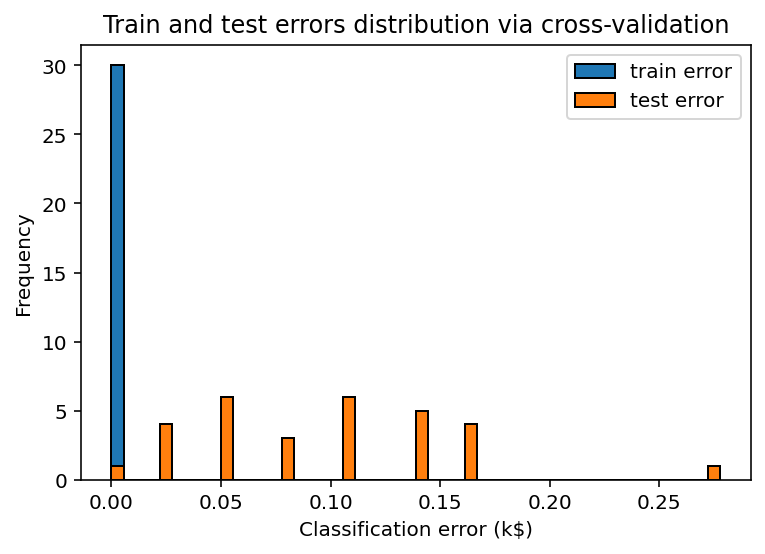

In [28]:
plt.figure(figsize=(20,15))
scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Classification error (k$)");
plt.title("Train and test errors distribution via cross-validation");

Plotting the distribution of the training and testing errors is one of the ways to get information about whether our model is over-fitting, under-fitting (or both at the same time).

Here, we observe a small training error, meaning that the model is not under-fitting: it is flexible enough to capture any variations present in the training set.

However the significantly larger testing error tells us that the model is over-fitting: the model has memorised many variations of the training set that could be considered "noisy" because they do not generalise to help us make good prediction on the test set.

#### Validation curve

Some model hyperparameters are usually the key to go from a model that underfits to a model that overfits, hopefully going through a region were we can get a good balance between the two. We can acquire knowledge by plotting a curve called the _validation curve_. 
This curve can also be applied to the above experiment and varies the value of a hyperparameter.

For the decision tree, the `max_depth` parameter is used to control the trade-off between under-fitting and over-fitting.



In [30]:
max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    decisiontree, X, y, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

Now that we collected the results, we will show the validation curve by plotting the training and testing errors (as well as their deviations).

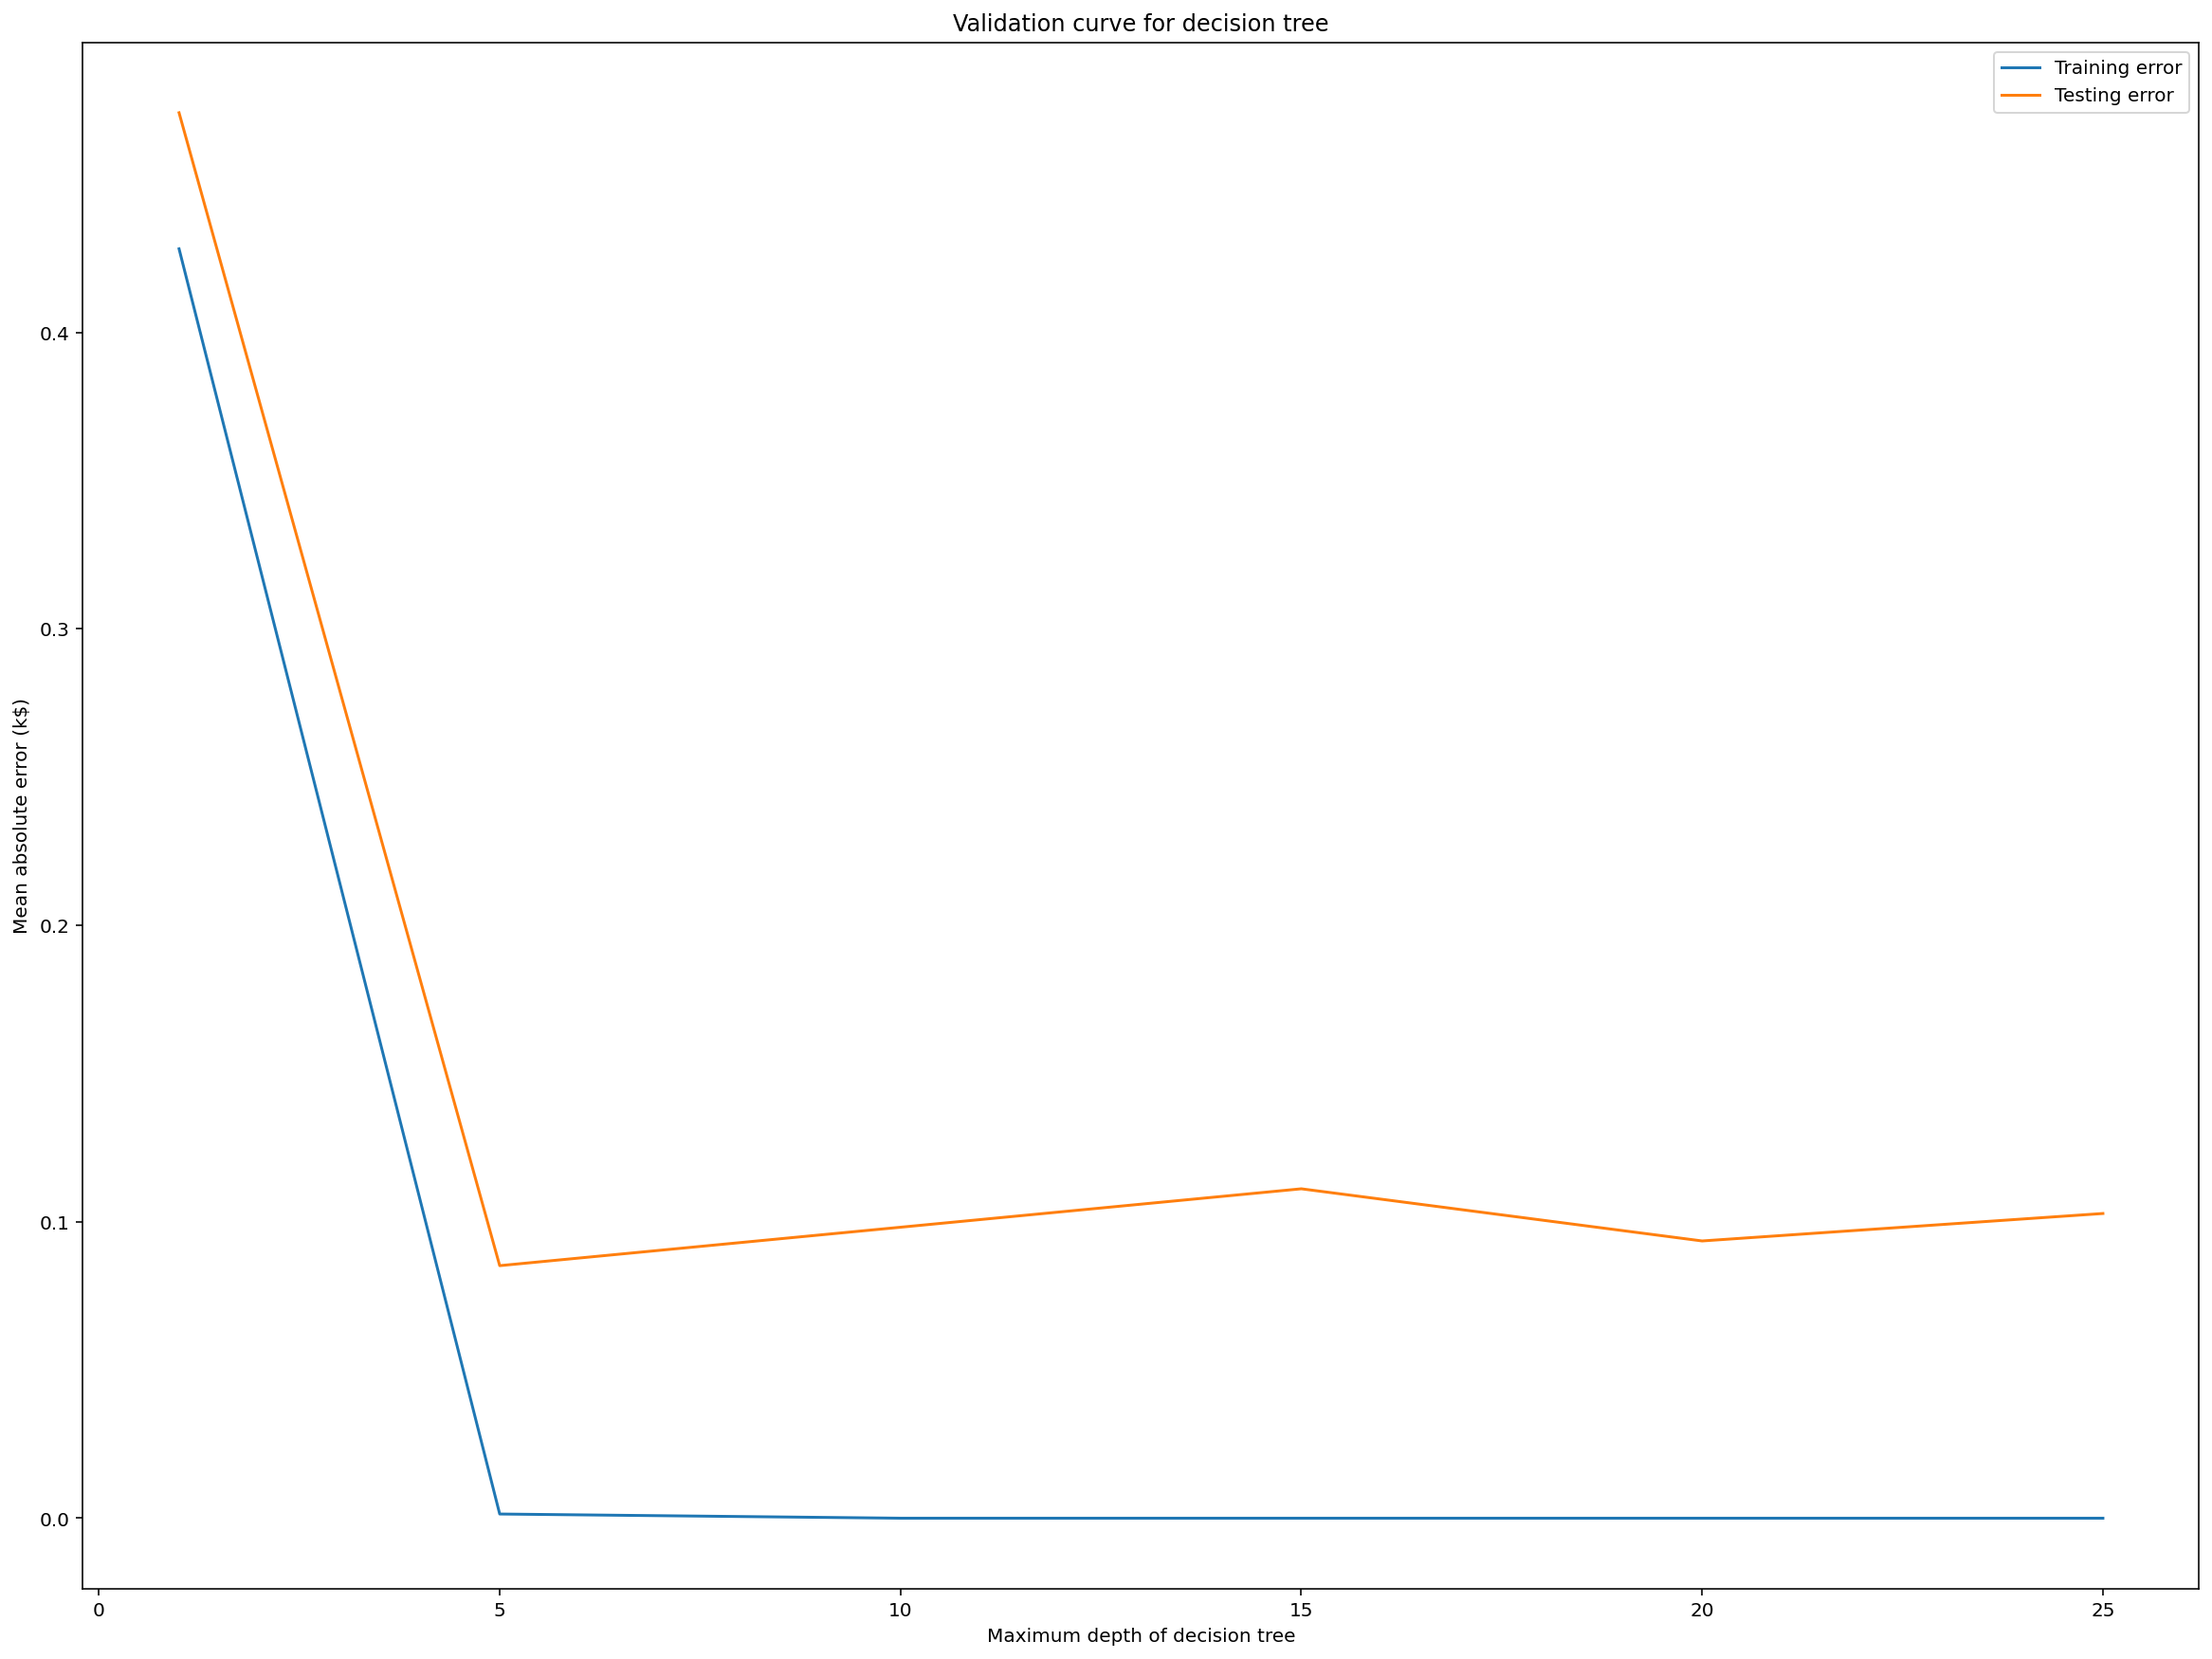

In [31]:
plt.figure(figsize=(20,15))
plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
plt.title("Validation curve for decision tree");

The validation curve can be divided into three areas:

- For `max_depth` $< 5$, the decision tree underfits. The training error and therefore the testing error are both high. The model is too constrained and cannot capture much of the variability of the target variable.

- The region around `max_depth` $= 5$ corresponds to the parameter for which the decision tree generalises the best. It is flexible enough to capture a fraction of the variability of the target that generalizes, while not memorising all of the noise in the target.

- For `max_depth` $> 7$, the decision tree overfits. The training error becomes very small, while the testing error increases. In this region, the models create decisions specifically for noisy samples harming its ability to generalize to test data.

Note that for `max_depth` $= 5$, the model overfits a bit as there is a gap between the training error and the testing error. It can also potentially underfit also a bit at the same time, because the training error is still far from zero, meaning that the model might still be too constrained to model interesting parts of the data. However, the testing error is minimal, and this is what really matters. This is the best compromise we could reach by just tuning this parameter.

Be aware that looking at the mean errors is quite limiting. We should also look at the standard deviation to assess the dispersion of the score. We can repeat the same plot as before but this time, we will add some information to show the standard deviation of the errors as well.

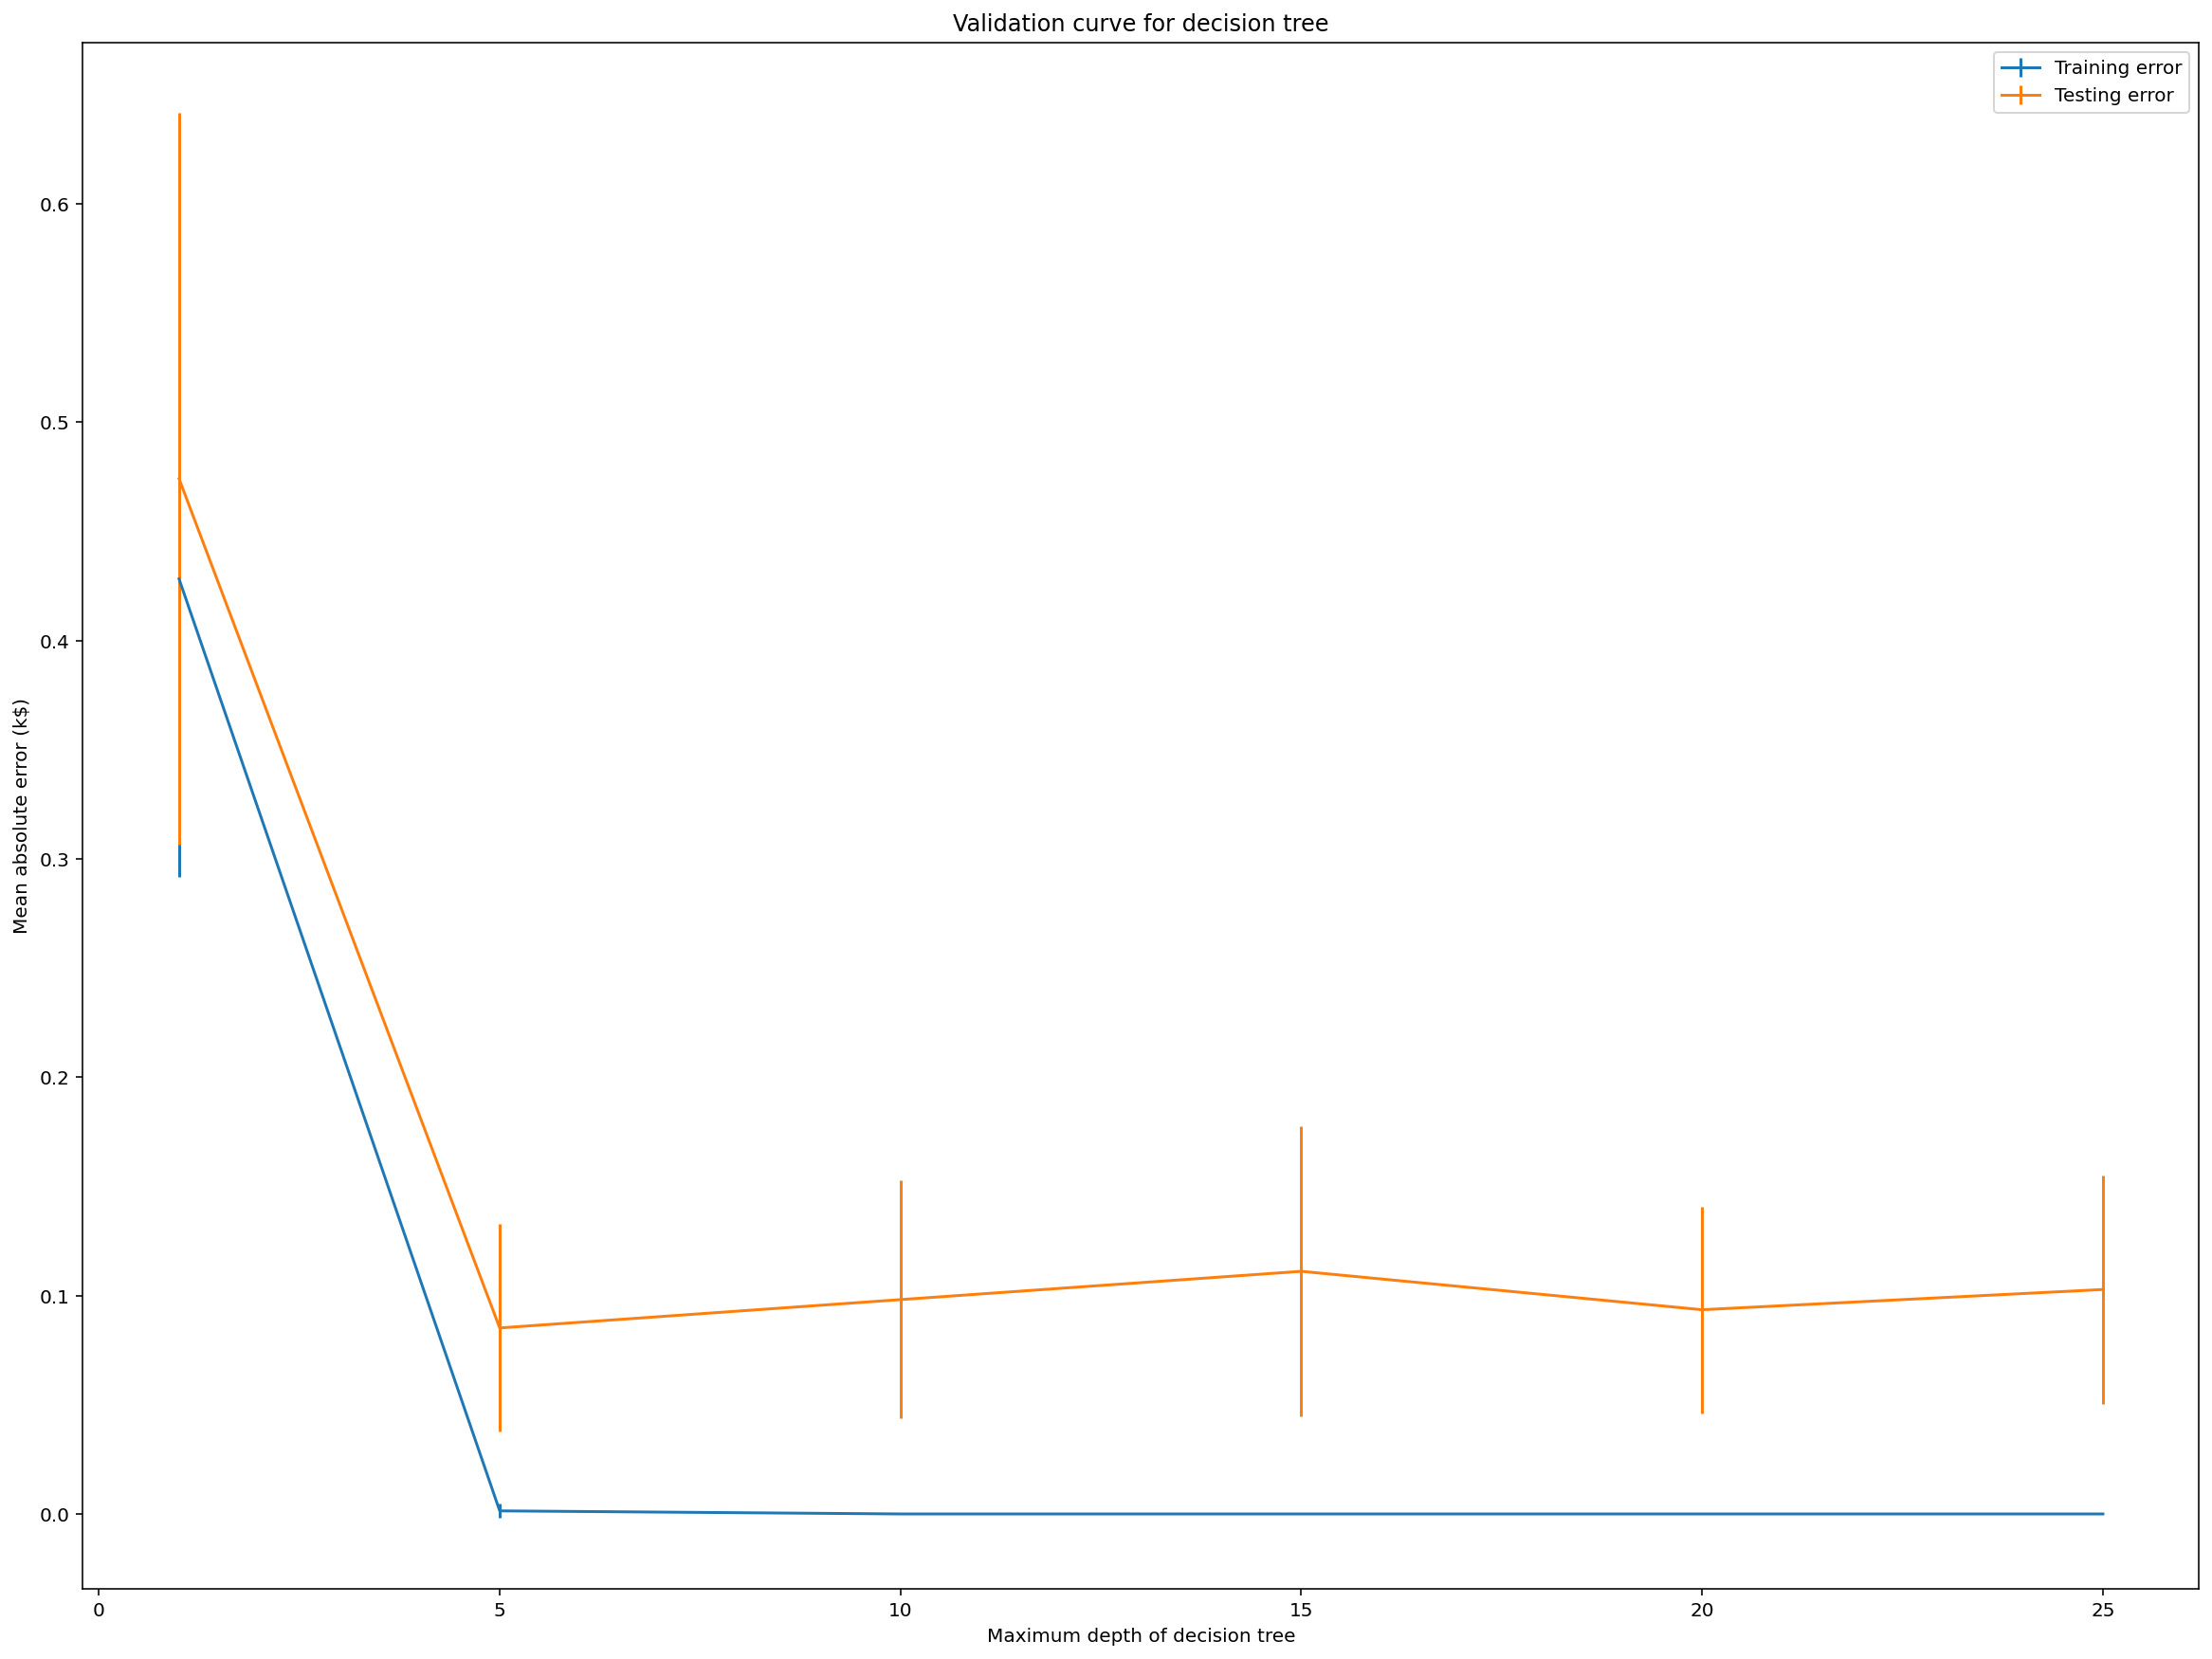

In [32]:
plt.figure(figsize=(20,15))
plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
plt.title("Validation curve for decision tree");

We were lucky that the variance of the errors was small compared to their respective values, and therefore the conclusions above are quite clear. 
This is not necessarily always the case.